In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV

In [2]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [3]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.

In [4]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import LabelEncoder, label_binarize

def train_phase(phase_path, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_fold = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled_np = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled_np = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled_np, columns=X_val.columns)

        # Encode target labels
        label_encoder = LabelEncoder()
        y_train_enc = label_encoder.fit_transform(y_train)
        y_val_enc = label_encoder.transform(y_val)
        class_names = label_encoder.classes_

        # Convert to NumPy arrays
        X_train_np = X_train_scaled.values
        X_val_np = X_val_scaled.values

        # Define and train TabNet model
        model = TabNetClassifier(
            seed=random_state,
            verbose=0
        )

        model.fit(
            X_train=X_train_np, y_train=y_train_enc,
            eval_set=[(X_train_np, y_train_enc), (X_val_np, y_val_enc)],
            eval_name=['train', 'val'],
            eval_metric=['balanced_accuracy'],
            max_epochs=100,
            patience=10,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0
        )

        # Plot training history
        history = model.history.history
        val_acc = history.get('val_balanced_accuracy', None)
        train_acc = history.get('train_balanced_accuracy', None)
        epochs = list(range(1, len(val_acc) + 1)) if val_acc else []
        
        if val_acc and train_acc:
            plt.figure(figsize=(6, 4))
            plt.plot(epochs, train_acc, label='Train Balanced Accuracy', marker='o', color='green')
            plt.plot(epochs, val_acc, label='Val Balanced Accuracy', marker='o', color='blue')
            plt.title(f'Fold {fold} - Balanced Accuracy per Epoch')
            plt.xlabel('Epoch')
            plt.ylabel('Balanced Accuracy')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

        # Evaluate
        y_pred_enc = model.predict(X_val_np)
        y_pred = label_encoder.inverse_transform(y_pred_enc)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        # AUC
        y_proba = model.predict_proba(X_val_np)
        y_val_bin = label_binarize(y_val_enc, classes=np.arange(len(class_names)))
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold
            best_label_encoder = label_encoder

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ROC Curves
        plt.figure(figsize=(8, 6))
        for i, class_label in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {class_label}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.title(f'Fold {fold} ROC Curves')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    # Feature Importances
    feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    print("\nFeature Importances:")
    print(feature_importances.head(10))

    return best_model, best_scaler, best_fold, all_metrics


In [5]:
pd.set_option('display.max_rows', None)


=== Training Phase 1 ===

Early stopping occurred at epoch 53 with best_epoch = 43 and best_val_balanced_accuracy = 0.32951


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


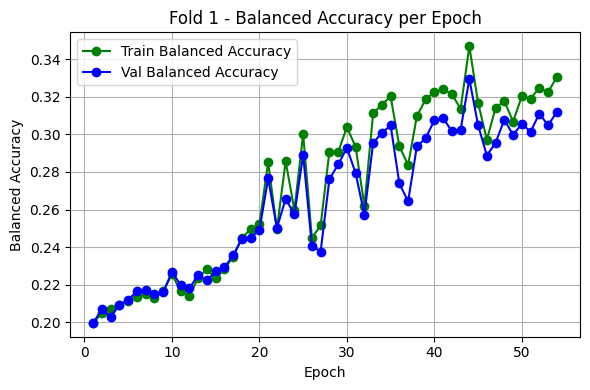

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.95      0.82      1785
           1       0.55      0.23      0.32       604
           2       0.52      0.17      0.26       258
           3       0.33      0.31      0.32        59
           4       0.00      0.00      0.00         9

    accuracy                           0.69      2715
   macro avg       0.43      0.33      0.34      2715
weighted avg       0.66      0.69      0.64      2715



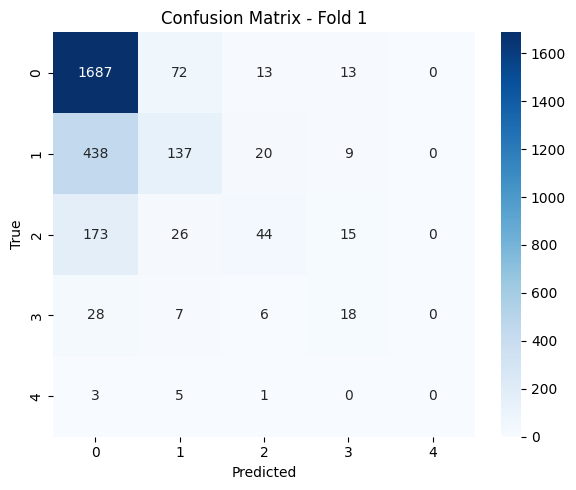

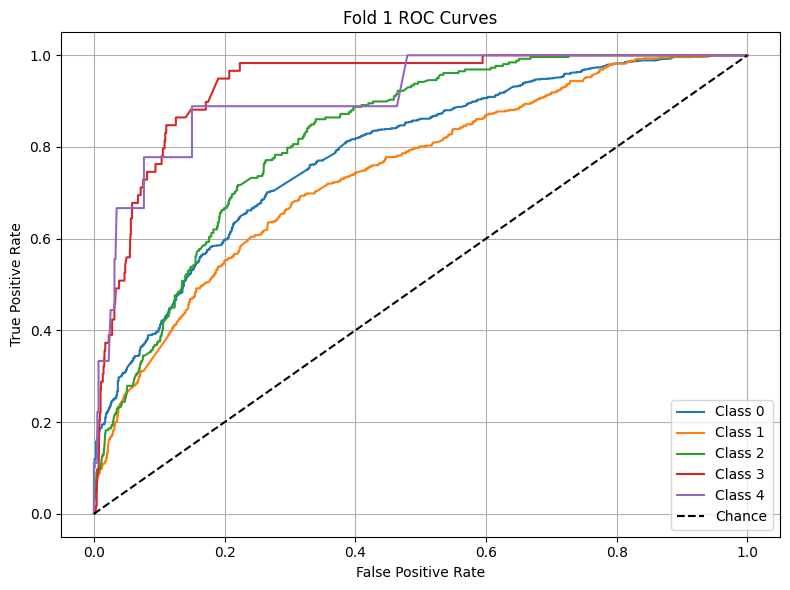


Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_balanced_accuracy = 0.3095


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


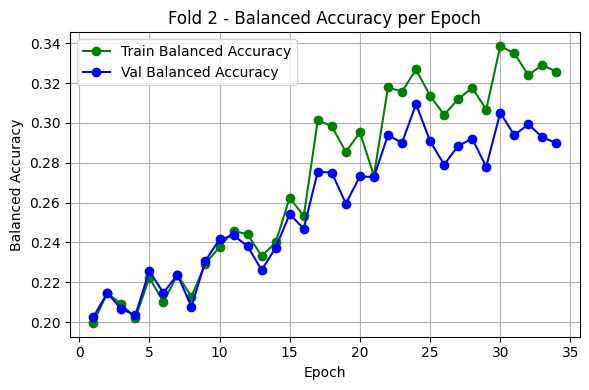

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.95      0.81      1786
           1       0.60      0.16      0.25       603
           2       0.48      0.18      0.26       258
           3       0.28      0.25      0.27        59
           4       0.00      0.00      0.00         8

    accuracy                           0.69      2714
   macro avg       0.42      0.31      0.32      2714
weighted avg       0.65      0.69      0.62      2714



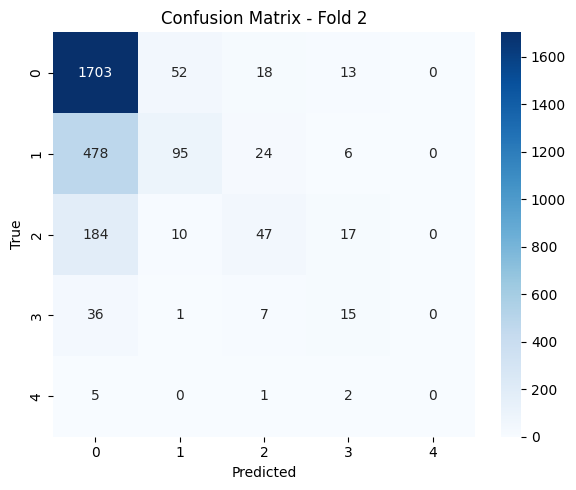

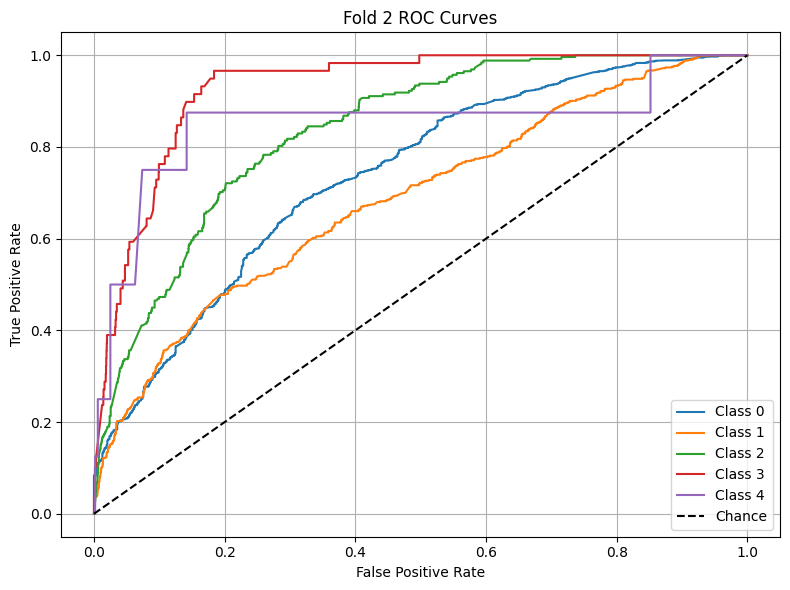


Early stopping occurred at epoch 57 with best_epoch = 47 and best_val_balanced_accuracy = 0.37977


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


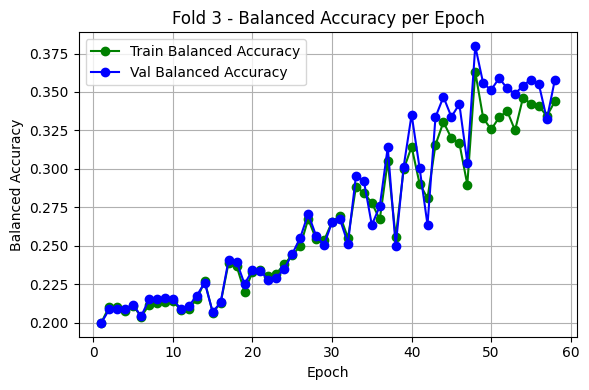


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.95      0.82      1786
           1       0.63      0.24      0.35       603
           2       0.51      0.22      0.31       258
           3       0.44      0.37      0.40        59
           4       1.00      0.12      0.22         8

    accuracy                           0.70      2714
   macro avg       0.66      0.38      0.42      2714
weighted avg       0.68      0.70      0.66      2714



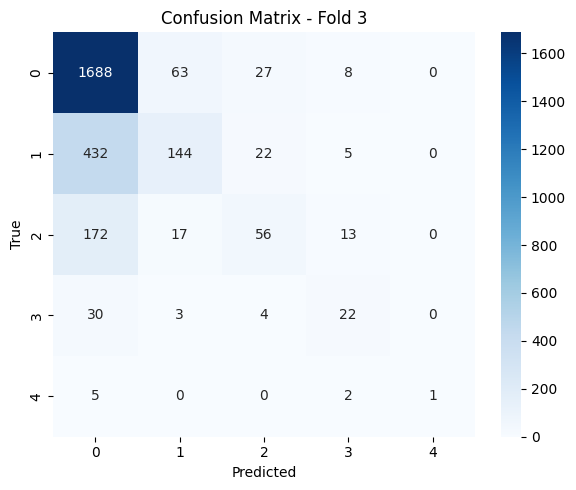

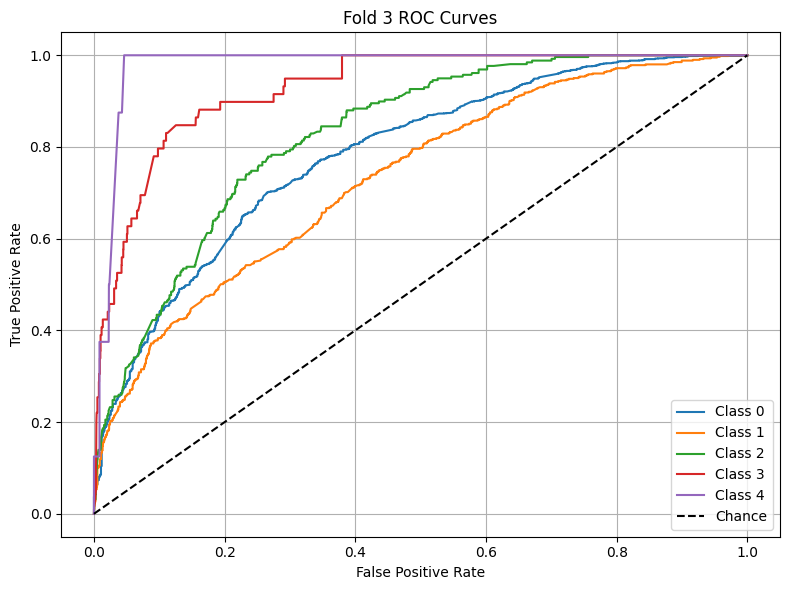


Early stopping occurred at epoch 46 with best_epoch = 36 and best_val_balanced_accuracy = 0.31832


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


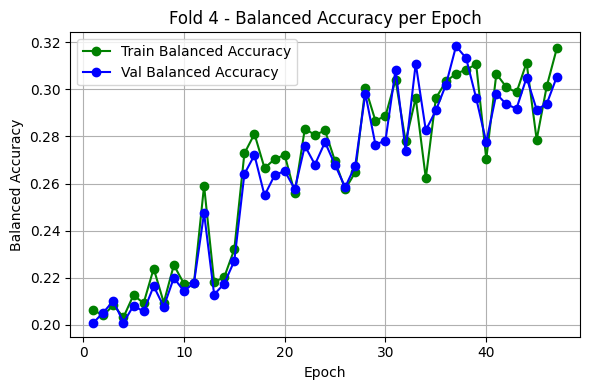

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.96      0.83      1785
           1       0.68      0.26      0.38       603
           2       0.54      0.14      0.23       258
           3       0.42      0.22      0.29        59
           4       0.00      0.00      0.00         9

    accuracy                           0.71      2714
   macro avg       0.47      0.32      0.34      2714
weighted avg       0.69      0.71      0.66      2714



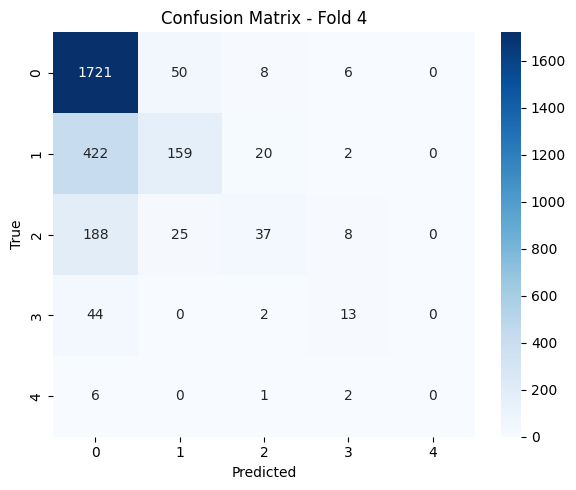

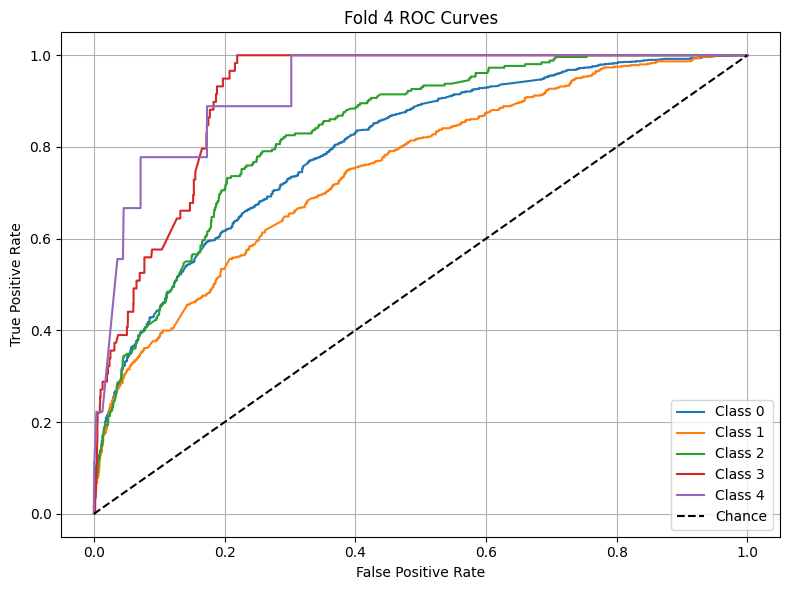


Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_balanced_accuracy = 0.35106


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


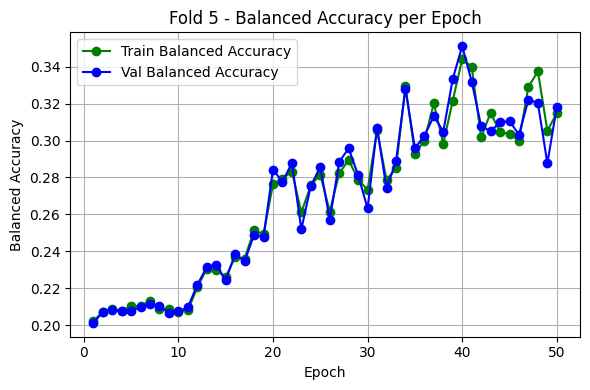

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.89      0.82      1785
           1       0.54      0.38      0.45       603
           2       0.42      0.25      0.31       258
           3       0.40      0.24      0.30        59
           4       0.00      0.00      0.00         9

    accuracy                           0.70      2714
   macro avg       0.42      0.35      0.37      2714
weighted avg       0.67      0.70      0.67      2714



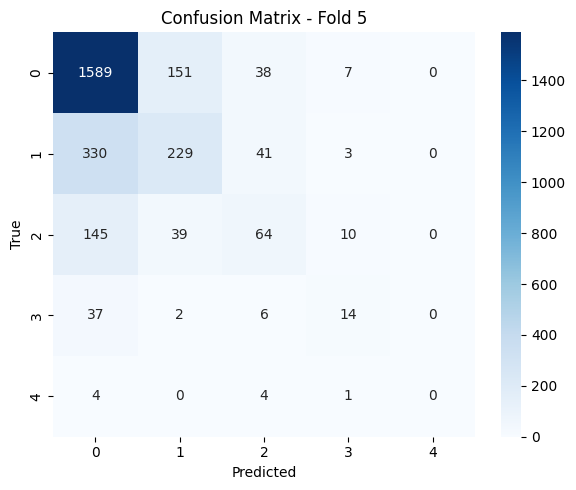

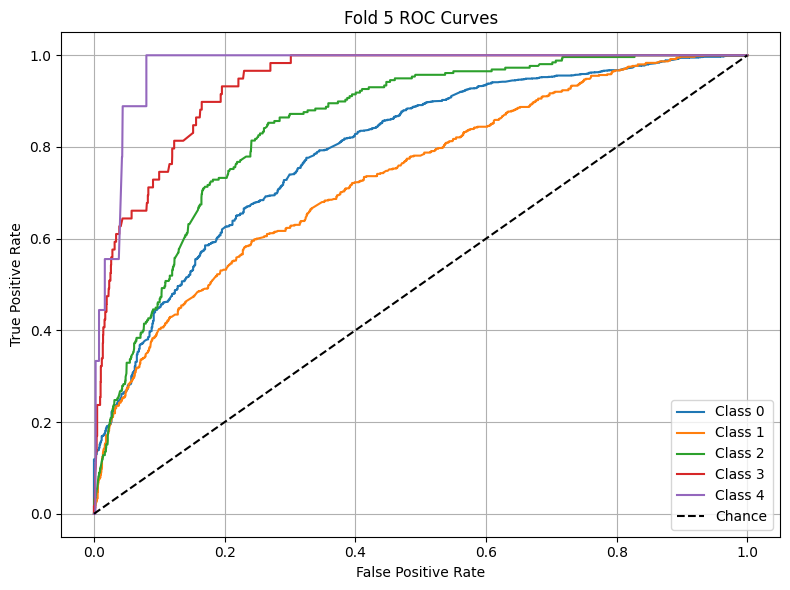


Average Accuracy: 0.6988
Average F1 Macro: 0.3602
Average AUC: 0.8401

Feature Importances:
assignment                0.286310
closeness                 0.112179
encoded_field_sum         0.078616
exercise_diff_mean_1      0.059447
video_count               0.050797
exercise_correct_sum_1    0.045864
video_speed_avg_1         0.042677
exercise_context_sum_1    0.036085
user_past_course_count    0.028995
eigenvector               0.026431
dtype: float64

=== Training Phase 2 ===

Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_balanced_accuracy = 0.29418


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


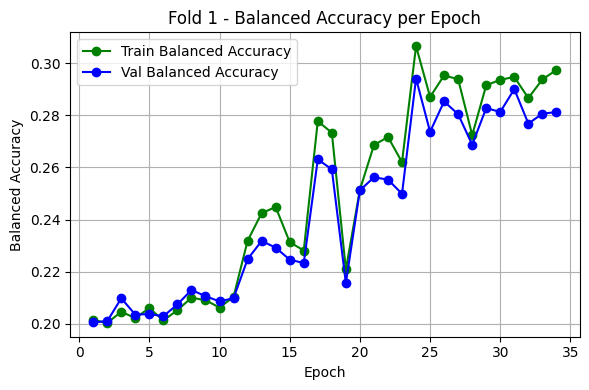

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.91      0.80      1489
           1       0.49      0.24      0.32       488
           2       0.51      0.15      0.24       220
           3       0.32      0.17      0.22        54
           4       0.00      0.00      0.00         9

    accuracy                           0.67      2260
   macro avg       0.41      0.29      0.31      2260
weighted avg       0.63      0.67      0.62      2260



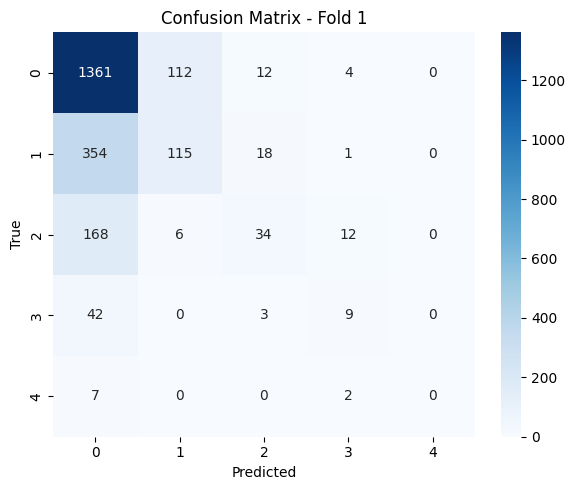

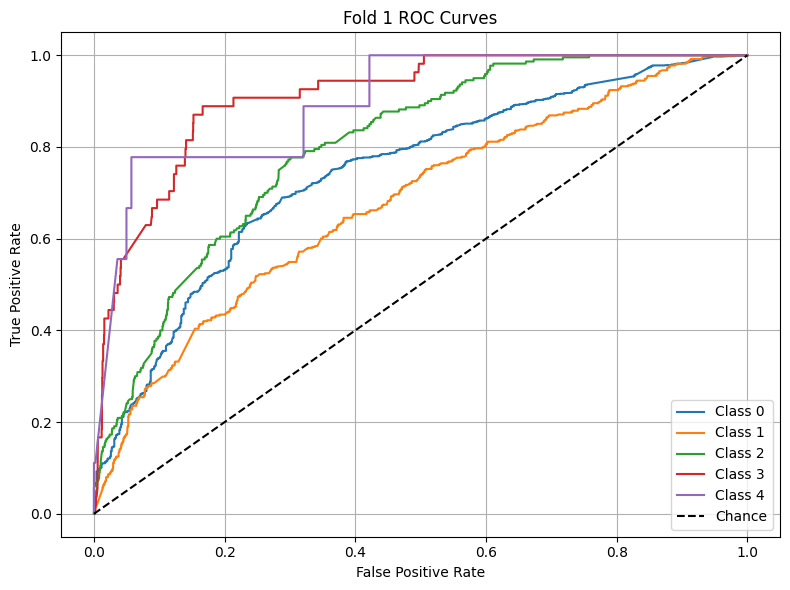


Early stopping occurred at epoch 89 with best_epoch = 79 and best_val_balanced_accuracy = 0.36818


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


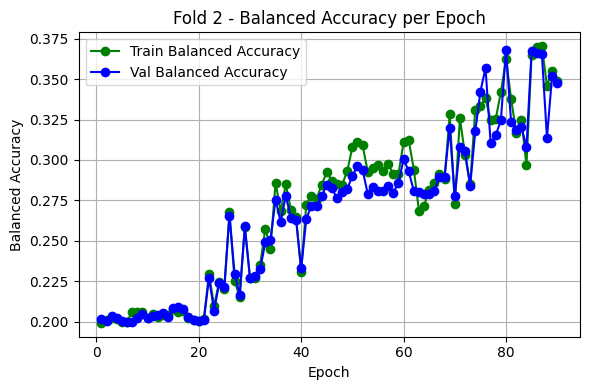

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.94      0.83      1489
           1       0.57      0.17      0.26       489
           2       0.44      0.37      0.40       219
           3       0.38      0.36      0.37        55
           4       0.00      0.00      0.00         8

    accuracy                           0.70      2260
   macro avg       0.43      0.37      0.37      2260
weighted avg       0.67      0.70      0.65      2260



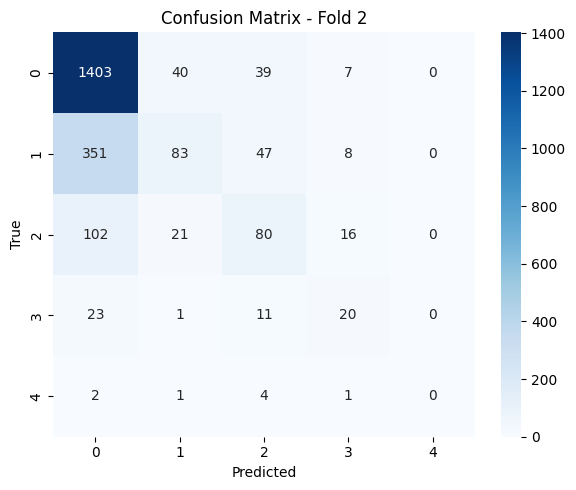

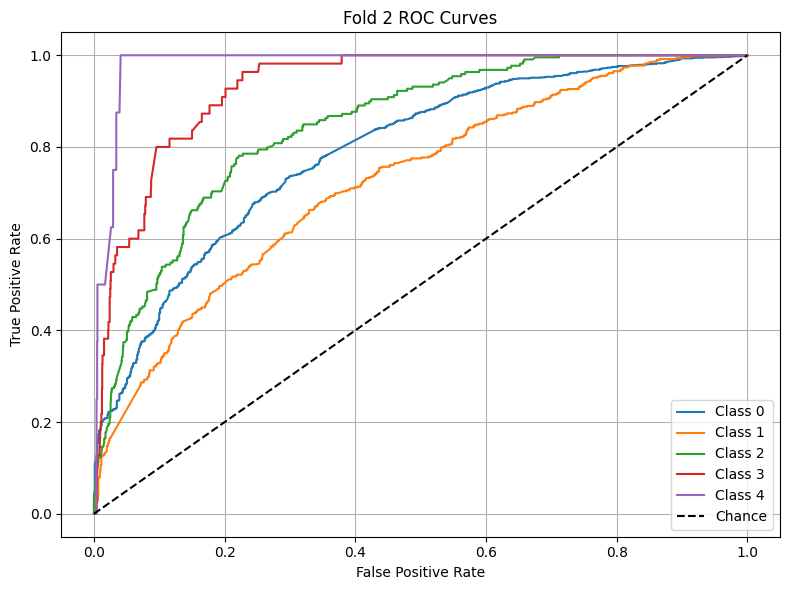


Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_balanced_accuracy = 0.29951


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


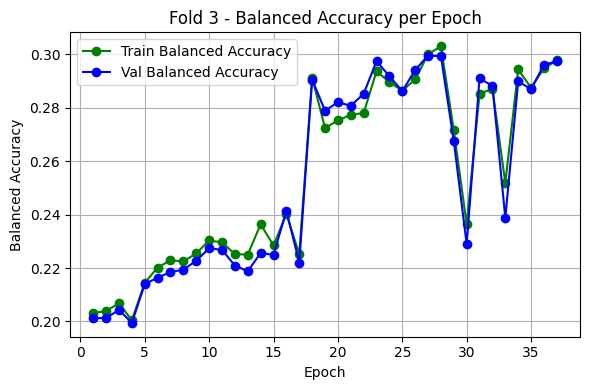

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.95      0.81      1489
           1       0.55      0.14      0.22       489
           2       0.35      0.13      0.19       219
           3       0.45      0.28      0.34        54
           4       0.00      0.00      0.00         8

    accuracy                           0.67      2259
   macro avg       0.41      0.30      0.31      2259
weighted avg       0.62      0.67      0.61      2259



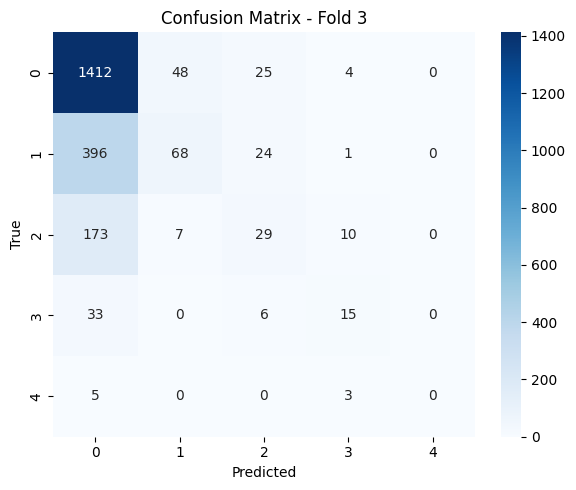

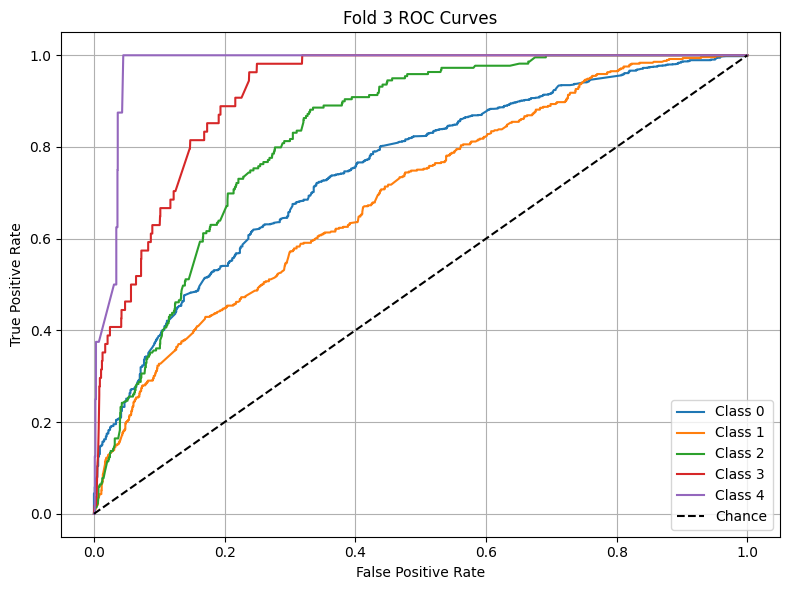


Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_balanced_accuracy = 0.37445


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


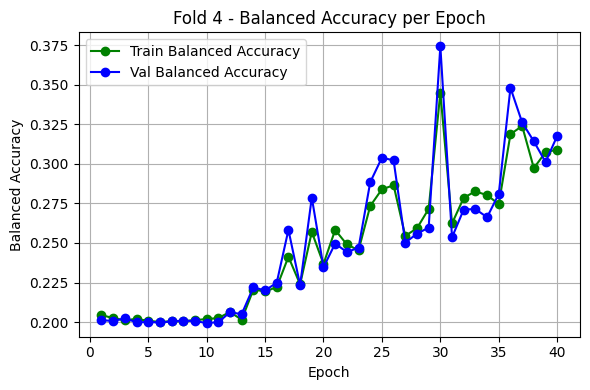

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.89      0.80      1489
           1       0.51      0.31      0.39       489
           2       0.42      0.17      0.25       219
           3       0.51      0.50      0.50        54
           4       0.00      0.00      0.00         8

    accuracy                           0.68      2259
   macro avg       0.43      0.37      0.39      2259
weighted avg       0.64      0.68      0.65      2259



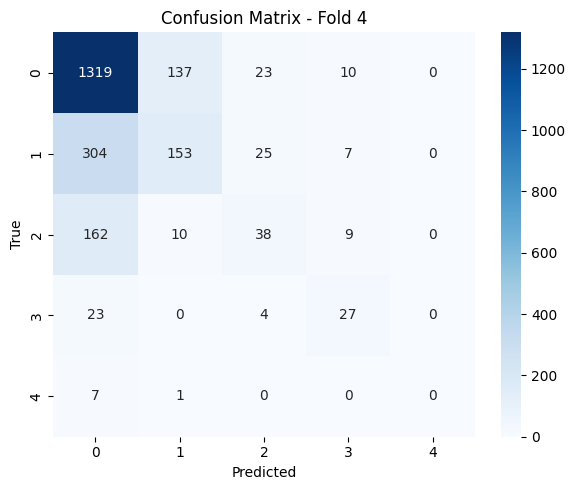

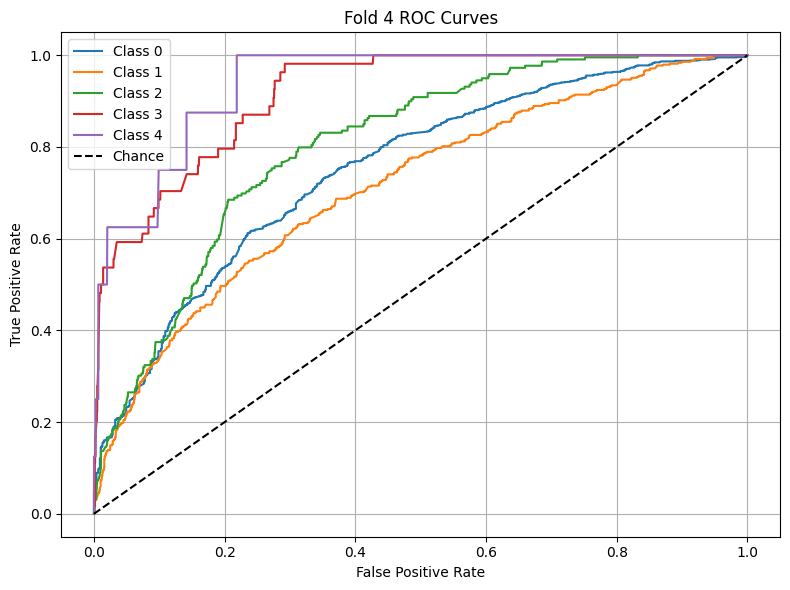


Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_balanced_accuracy = 0.29869


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


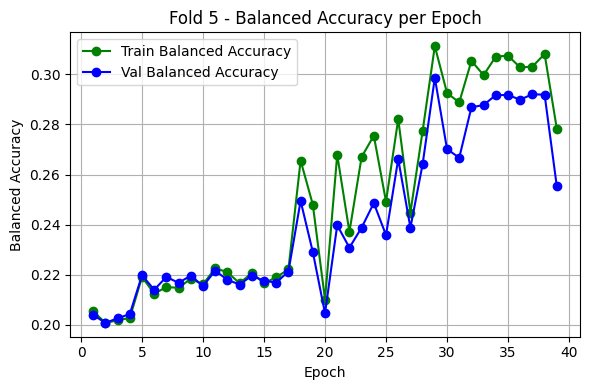


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.96      0.82      1490
           1       0.61      0.13      0.21       488
           2       0.38      0.20      0.26       219
           3       0.42      0.20      0.27        54
           4       0.00      0.00      0.00         8

    accuracy                           0.69      2259
   macro avg       0.42      0.30      0.31      2259
weighted avg       0.65      0.69      0.62      2259



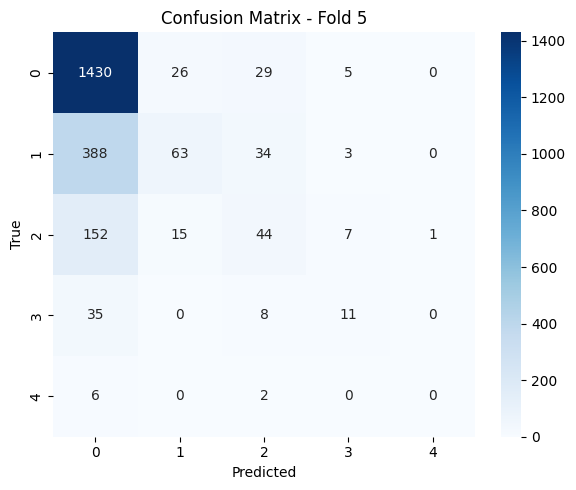

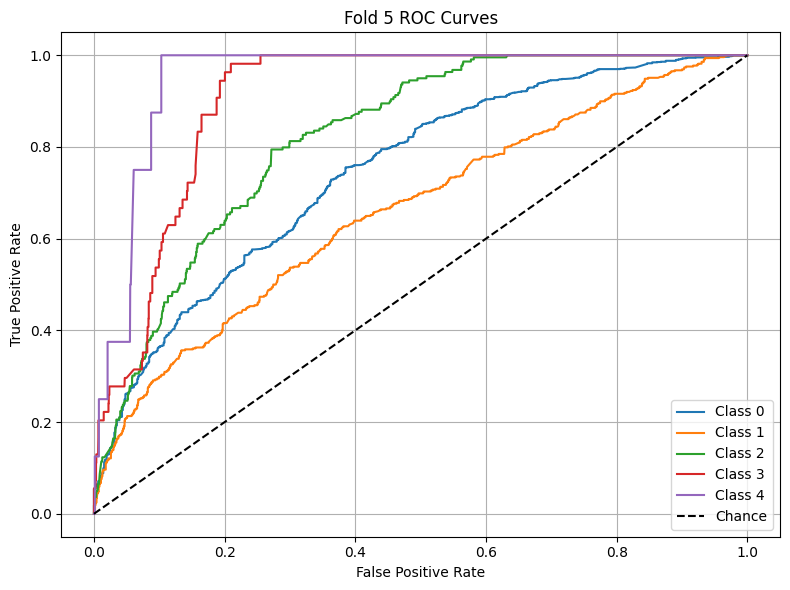


Average Accuracy: 0.6828
Average F1 Macro: 0.3402
Average AUC: 0.8273

Feature Importances:
assignment                             0.228923
encoded_field_sum                      0.118942
closeness                              0.066977
total_positive2                        0.061215
chapter_count                          0.055112
exercise_perc_real_completed_mean_1    0.054210
num_prerequisites                      0.048037
video_watched_percentage_2             0.047590
eigenvector                            0.039098
school                                 0.037364
dtype: float64

=== Training Phase 3 ===

Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_balanced_accuracy = 0.26099


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


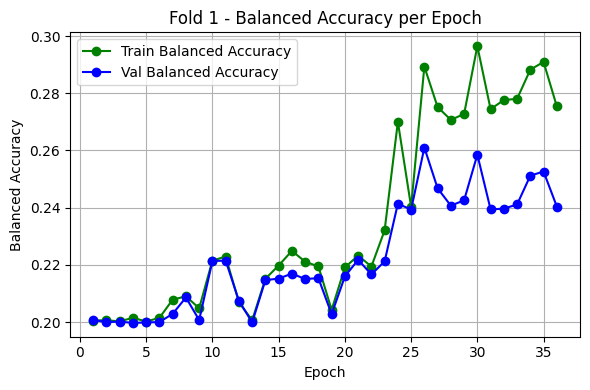

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.94      0.80      1361
           1       0.51      0.20      0.29       459
           2       0.25      0.07      0.10       198
           3       0.19      0.10      0.13        49
           4       0.00      0.00      0.00         7

    accuracy                           0.67      2074
   macro avg       0.33      0.26      0.27      2074
weighted avg       0.60      0.67      0.60      2074



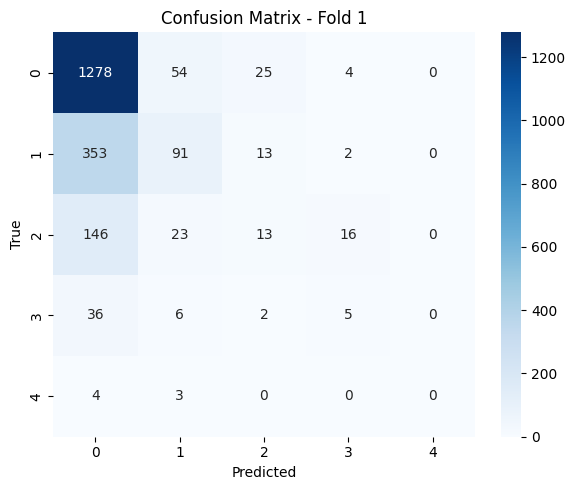

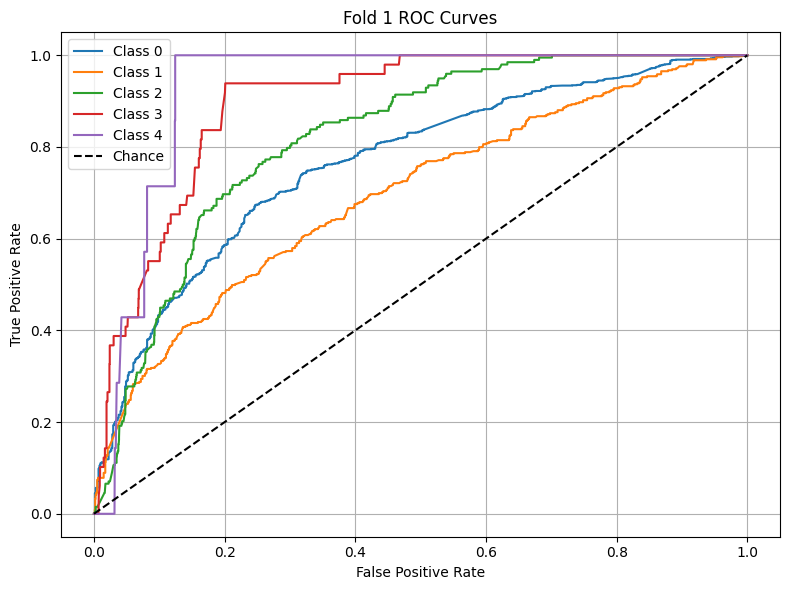


Early stopping occurred at epoch 47 with best_epoch = 37 and best_val_balanced_accuracy = 0.32046


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


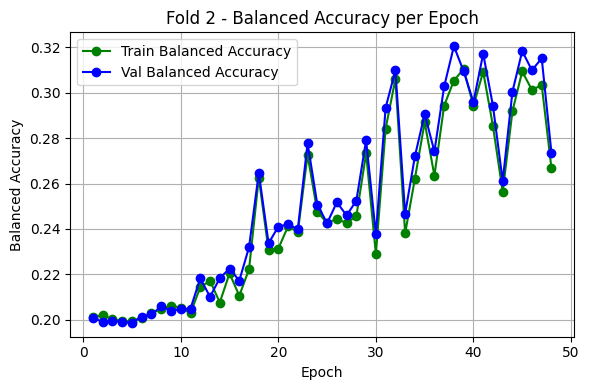

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.96      0.81      1360
           1       0.66      0.17      0.27       459
           2       0.57      0.22      0.31       198
           3       0.50      0.26      0.34        50
           4       0.00      0.00      0.00         7

    accuracy                           0.69      2074
   macro avg       0.49      0.32      0.35      2074
weighted avg       0.67      0.69      0.63      2074



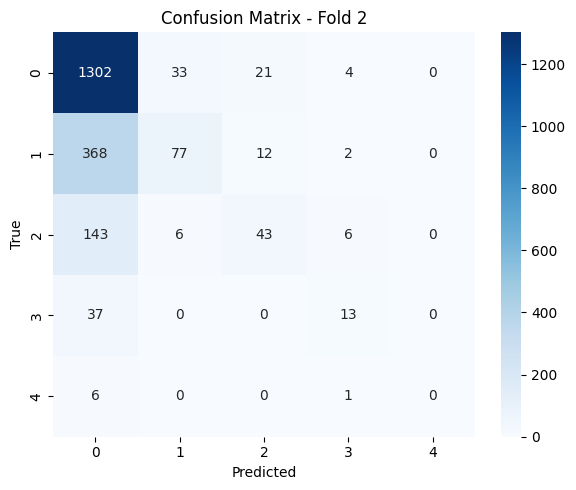

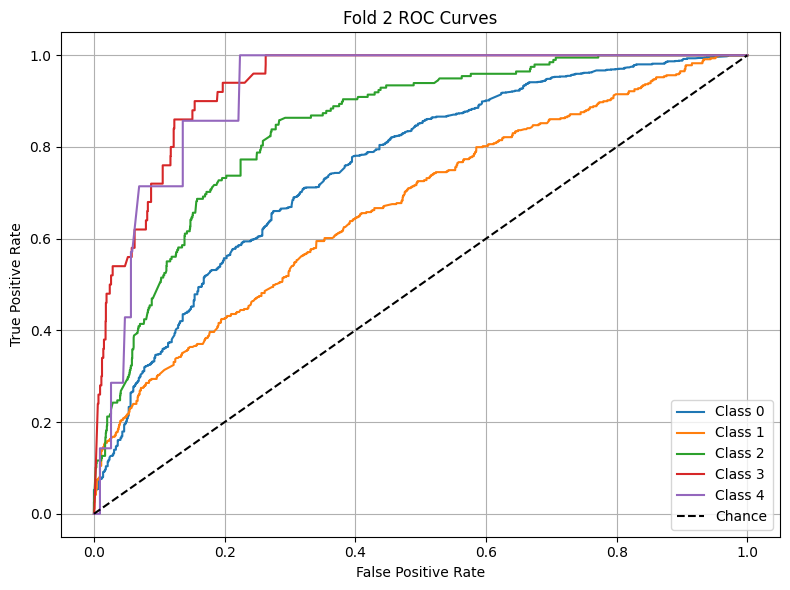


Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_balanced_accuracy = 0.22943


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


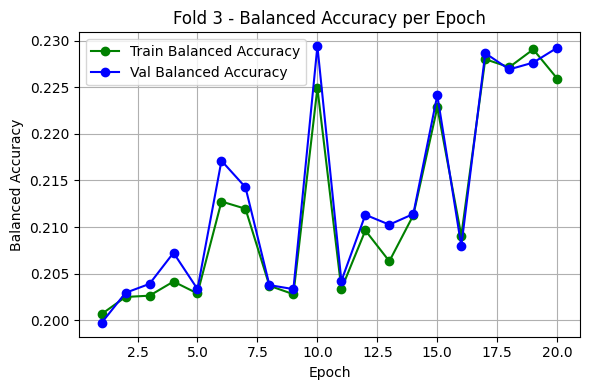

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.98      0.80      1360
           1       0.74      0.15      0.25       459
           2       0.50      0.01      0.02       198
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00         7

    accuracy                           0.68      2074
   macro avg       0.38      0.23      0.22      2074
weighted avg       0.66      0.68      0.58      2074



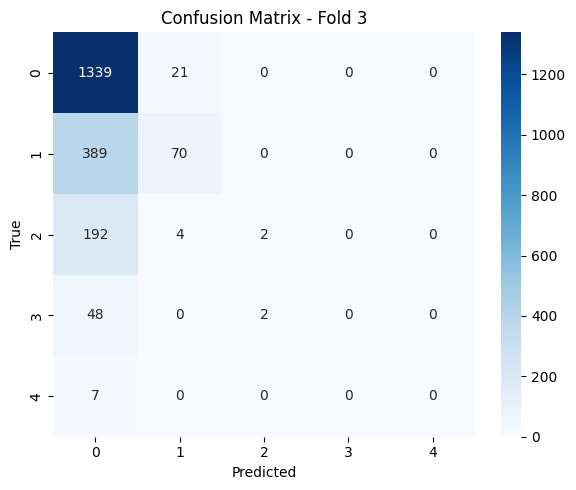

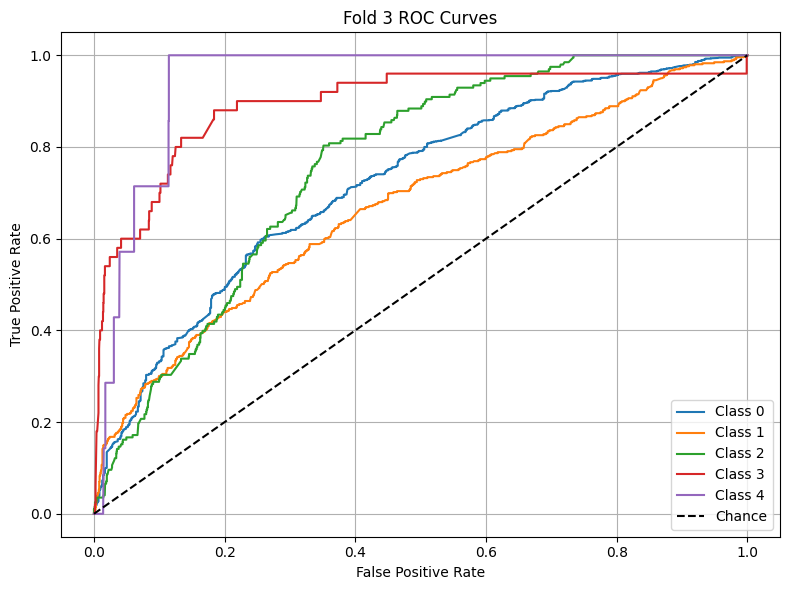


Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_balanced_accuracy = 0.20273


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


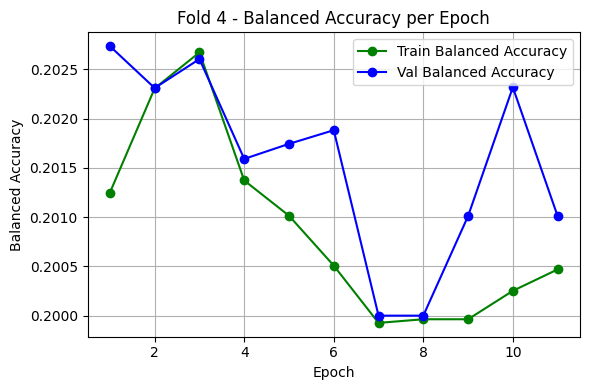

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.99      0.79      1360
           1       0.39      0.02      0.05       459
           2       0.00      0.00      0.00       198
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00         7

    accuracy                           0.65      2074
   macro avg       0.21      0.20      0.17      2074
weighted avg       0.52      0.65      0.53      2074



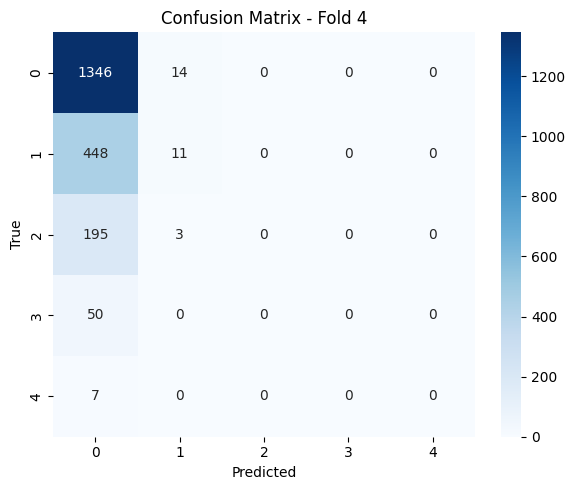

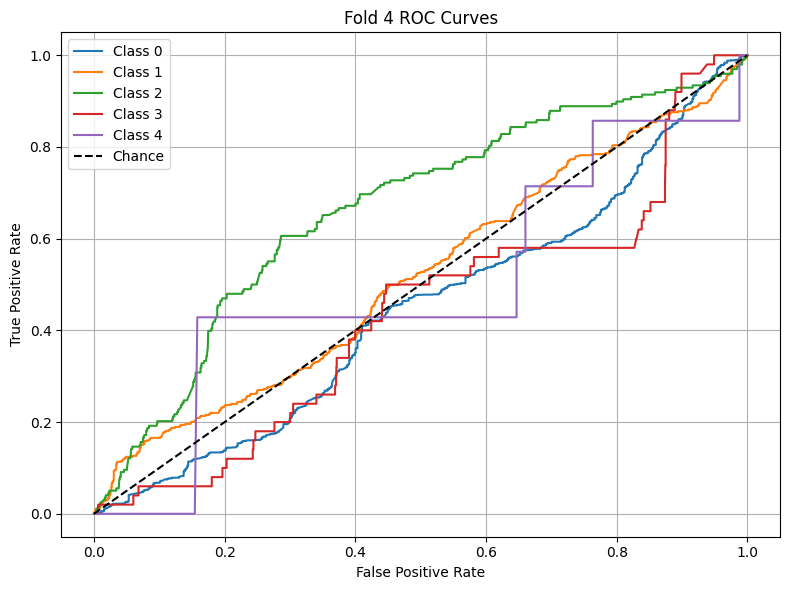


Early stopping occurred at epoch 73 with best_epoch = 63 and best_val_balanced_accuracy = 0.35934


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


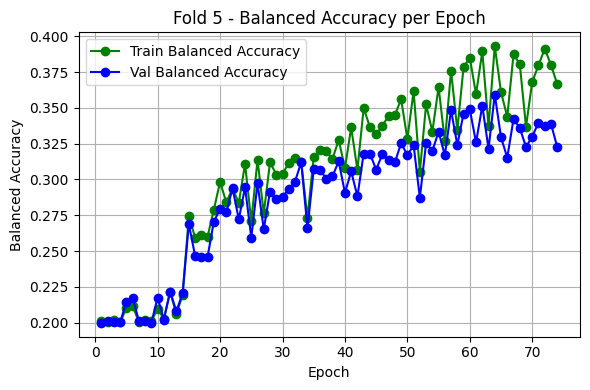

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.92      0.81      1360
           1       0.54      0.19      0.28       460
           2       0.41      0.34      0.37       197
           3       0.40      0.35      0.37        49
           4       0.00      0.00      0.00         7

    accuracy                           0.68      2073
   macro avg       0.42      0.36      0.37      2073
weighted avg       0.65      0.68      0.64      2073



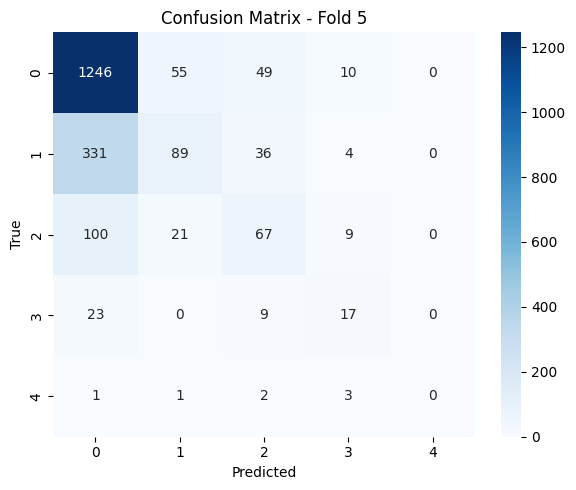

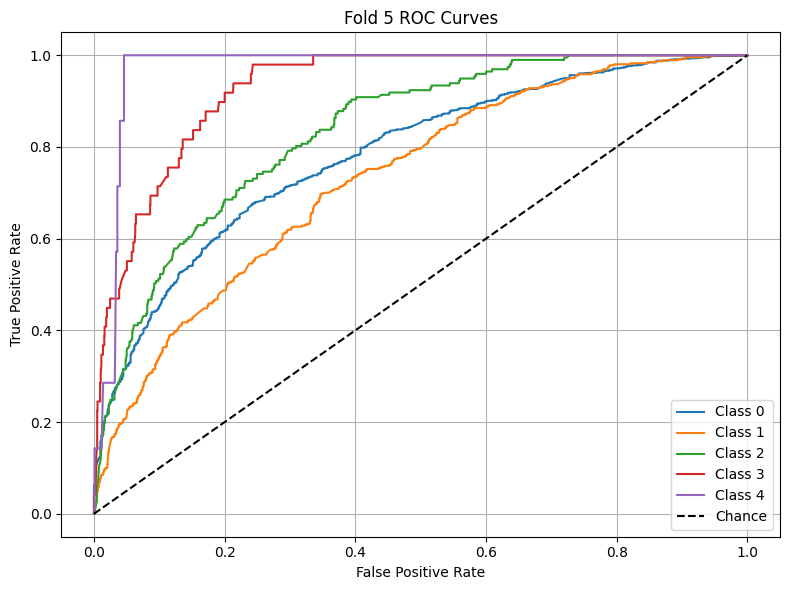


Average Accuracy: 0.6760
Average F1 Macro: 0.2724
Average AUC: 0.7611

Feature Importances:
assignment                      0.240586
closeness                       0.105735
cluster                         0.100612
certificate                     0.091272
duration_days                   0.069967
exercise_attempts_sum_mean_1    0.057387
exercise_context_sum_2          0.051507
video                           0.048632
exercise_correct_sum_1          0.034724
total_positive3                 0.034547
dtype: float64

=== Training Phase 4 ===

Early stopping occurred at epoch 76 with best_epoch = 66 and best_val_balanced_accuracy = 0.37794


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


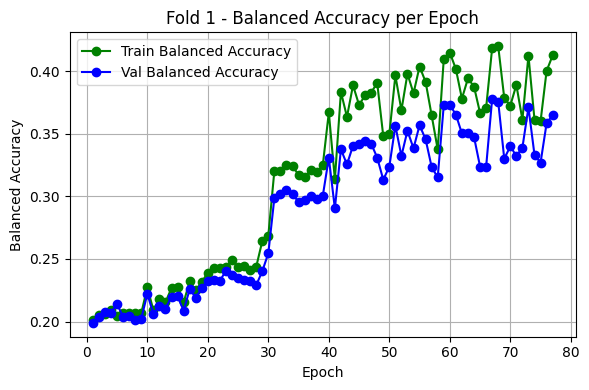

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.89      0.82      1000
           1       0.51      0.30      0.38       355
           2       0.34      0.27      0.30       139
           3       0.34      0.44      0.38        39
           4       0.00      0.00      0.00         6

    accuracy                           0.68      1539
   macro avg       0.39      0.38      0.38      1539
weighted avg       0.65      0.68      0.66      1539



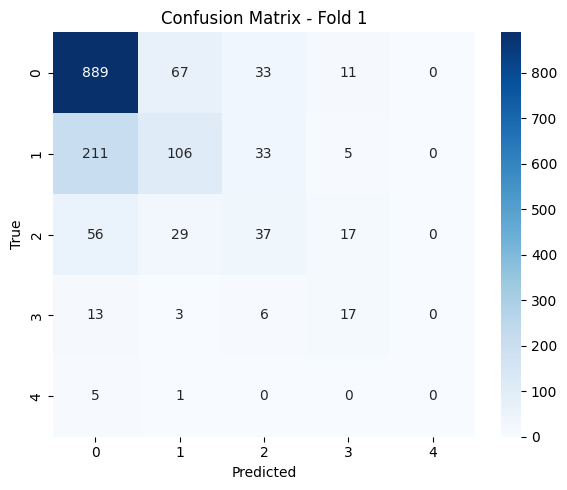

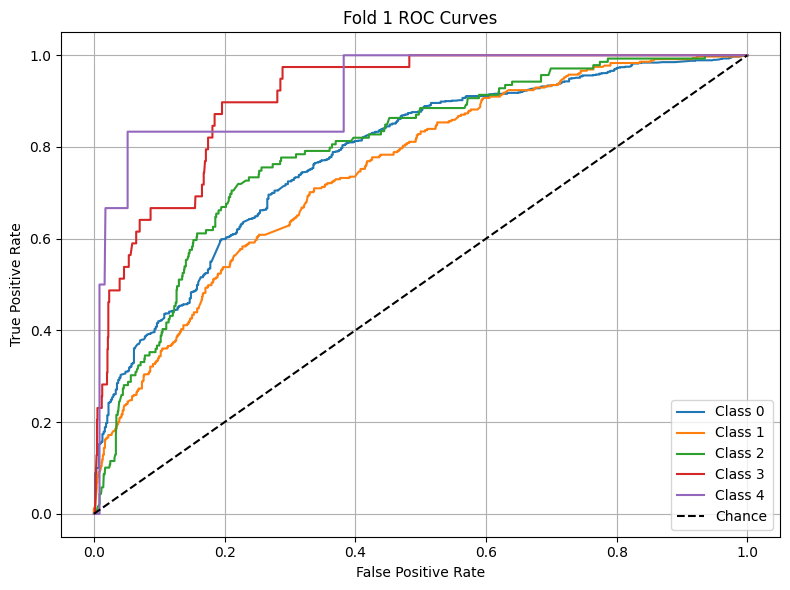


Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_balanced_accuracy = 0.35399


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


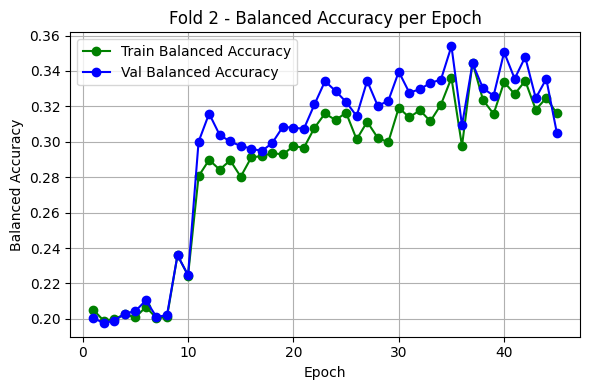

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.94      0.82      1000
           1       0.63      0.23      0.33       355
           2       0.43      0.25      0.32       139
           3       0.50      0.35      0.41        40
           4       0.00      0.00      0.00         5

    accuracy                           0.70      1539
   macro avg       0.46      0.35      0.38      1539
weighted avg       0.67      0.70      0.65      1539



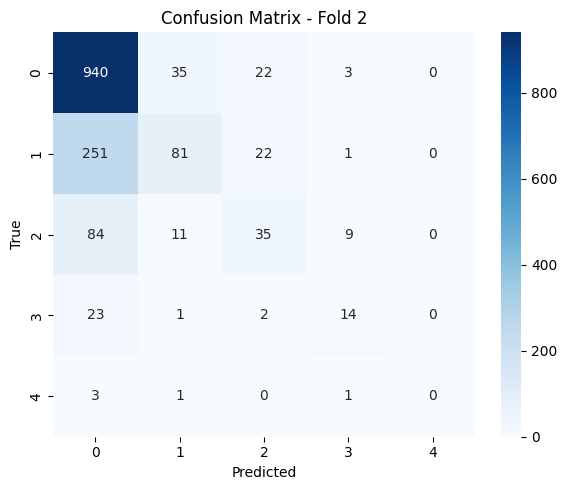

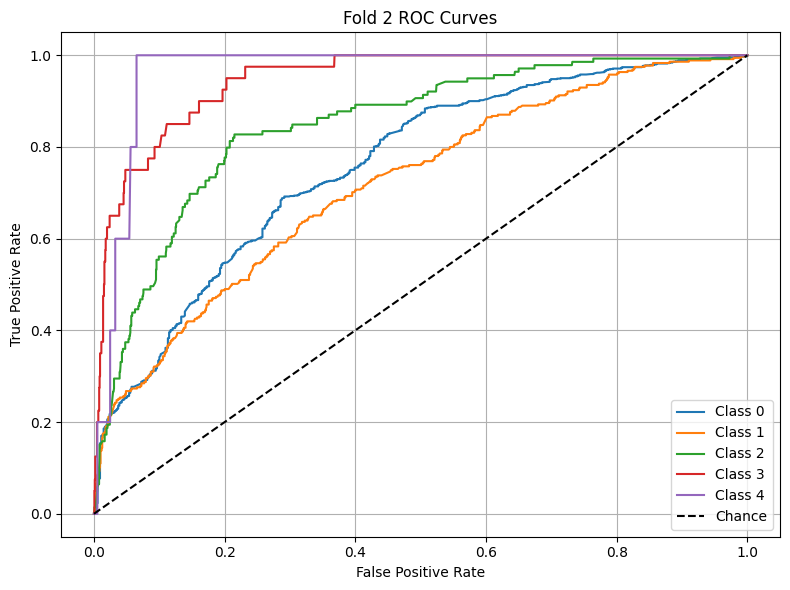


Early stopping occurred at epoch 55 with best_epoch = 45 and best_val_balanced_accuracy = 0.37098


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


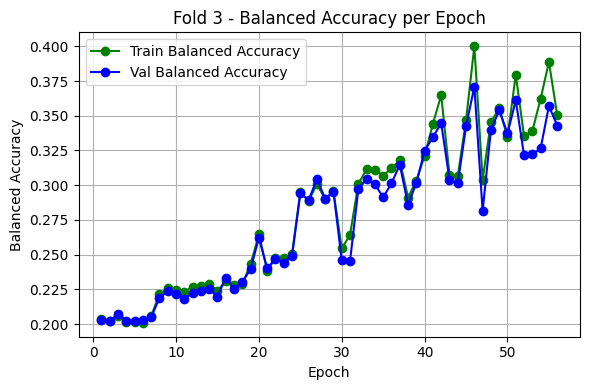

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.87      0.81       999
           1       0.54      0.42      0.47       355
           2       0.35      0.12      0.17       139
           3       0.34      0.45      0.39        40
           4       0.00      0.00      0.00         6

    accuracy                           0.68      1539
   macro avg       0.39      0.37      0.37      1539
weighted avg       0.65      0.68      0.66      1539



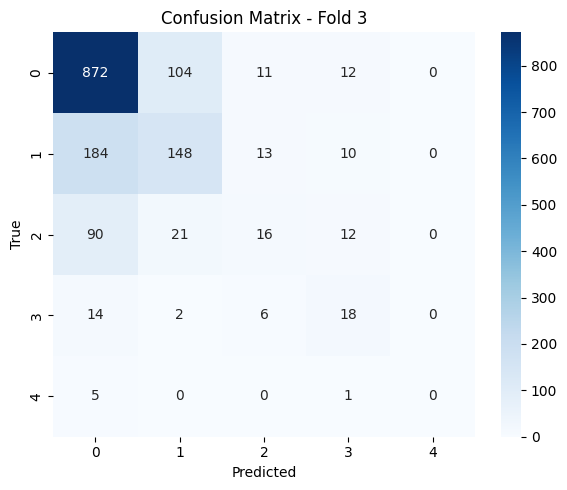

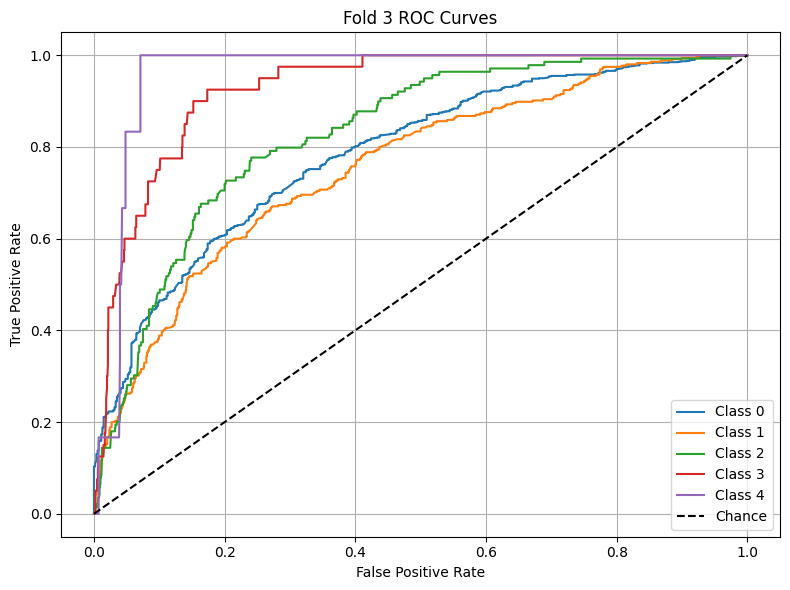


Early stopping occurred at epoch 48 with best_epoch = 38 and best_val_balanced_accuracy = 0.34686


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


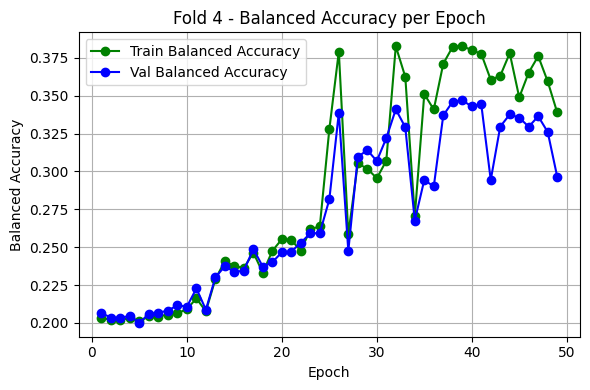

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.93      0.83       999
           1       0.54      0.30      0.39       356
           2       0.45      0.12      0.19       138
           3       0.25      0.38      0.30        39
           4       0.00      0.00      0.00         6

    accuracy                           0.69      1538
   macro avg       0.40      0.35      0.34      1538
weighted avg       0.66      0.69      0.65      1538



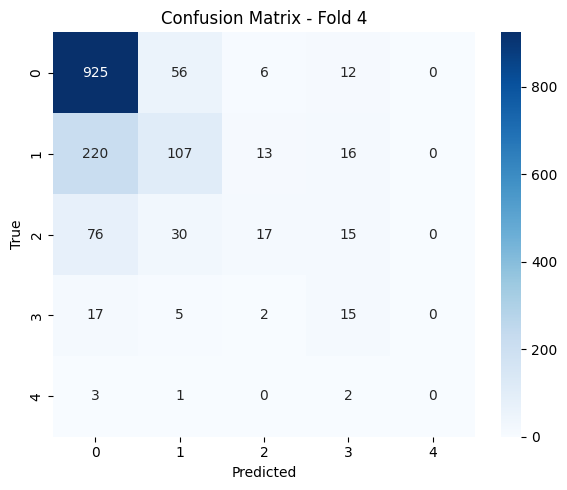

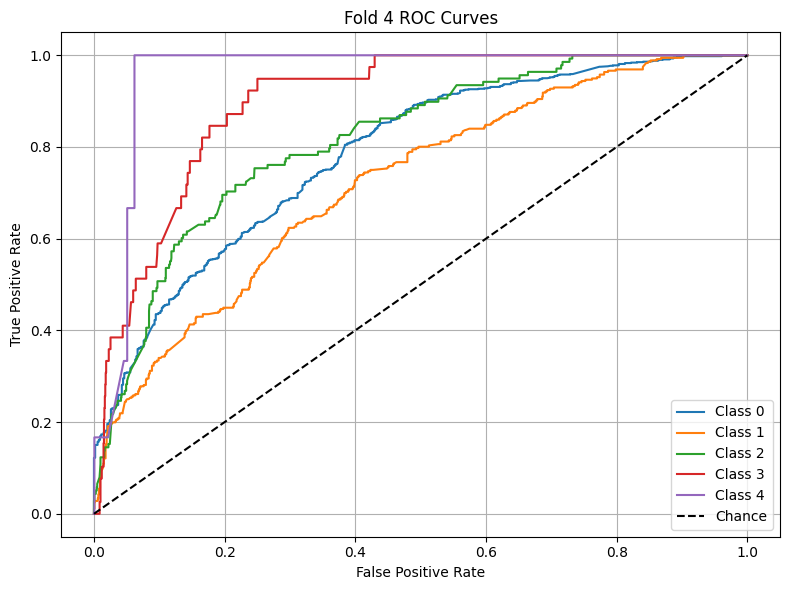


Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_balanced_accuracy = 0.20659


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


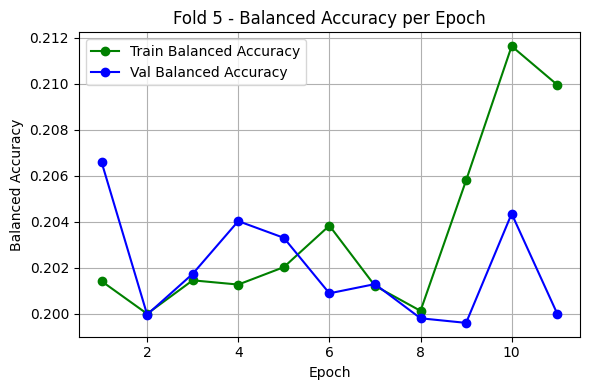

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.99      0.79       999
           1       0.57      0.03      0.06       356
           2       0.33      0.01      0.01       138
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00         6

    accuracy                           0.65      1538
   macro avg       0.31      0.21      0.17      1538
weighted avg       0.59      0.65      0.53      1538



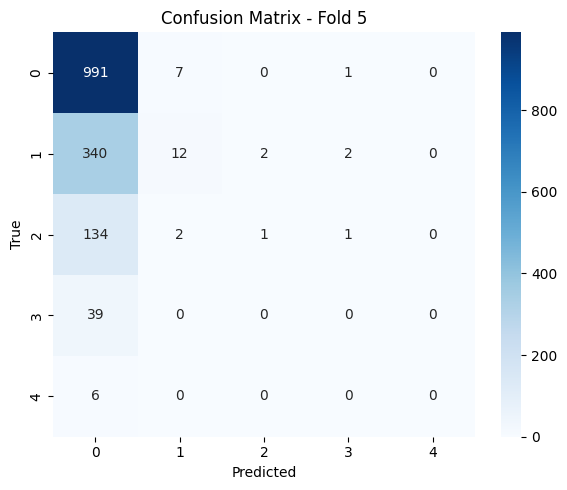

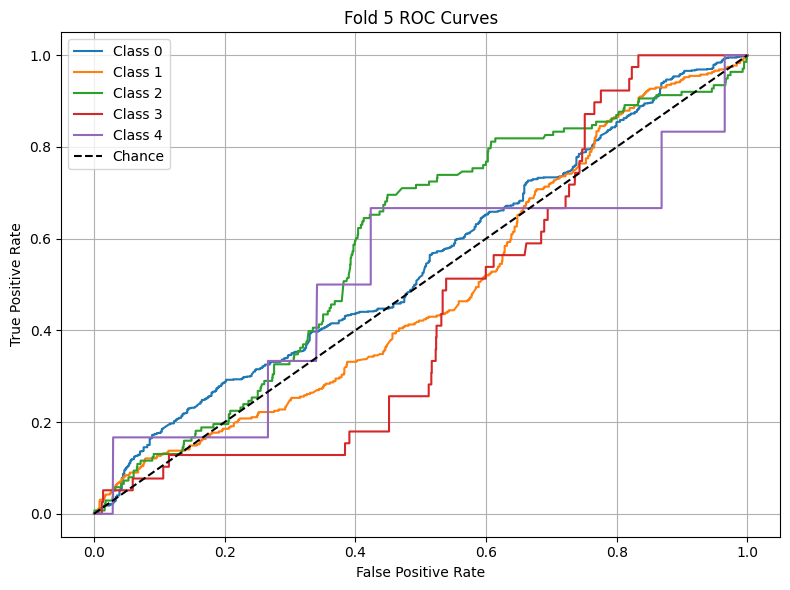


Average Accuracy: 0.6813
Average F1 Macro: 0.3268
Average AUC: 0.7760

Feature Importances:
assignment                    0.222281
video_count                   0.119144
exercise_count                0.112464
encoded_field_sum             0.093365
user_month                    0.067076
closeness                     0.064844
duration_days                 0.060248
eigenvector                   0.033847
degree                        0.031719
video_watched_percentage_1    0.024593
dtype: float64


In [6]:
phase_paths = [f"/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


## Predict on Test Data

In [7]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    classes = model.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       568
           1       0.28      0.22      0.25        63
           2       0.27      0.23      0.25        43
           3       0.25      0.07      0.11        15
           4       0.00      0.00      0.00         9

    accuracy                           0.79       698
   macro avg       0.33      0.29      0.30       698
weighted avg       0.76      0.79      0.77       698



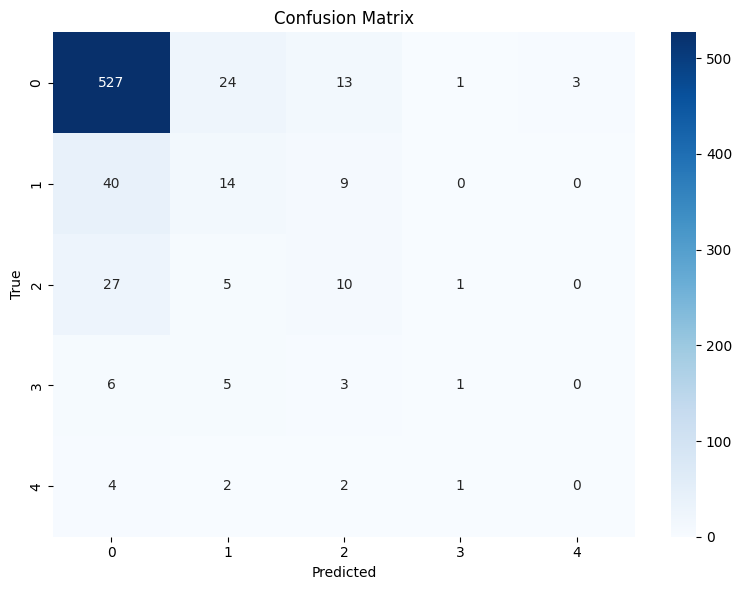


Test AUC (macro-average, OVR): 0.7629


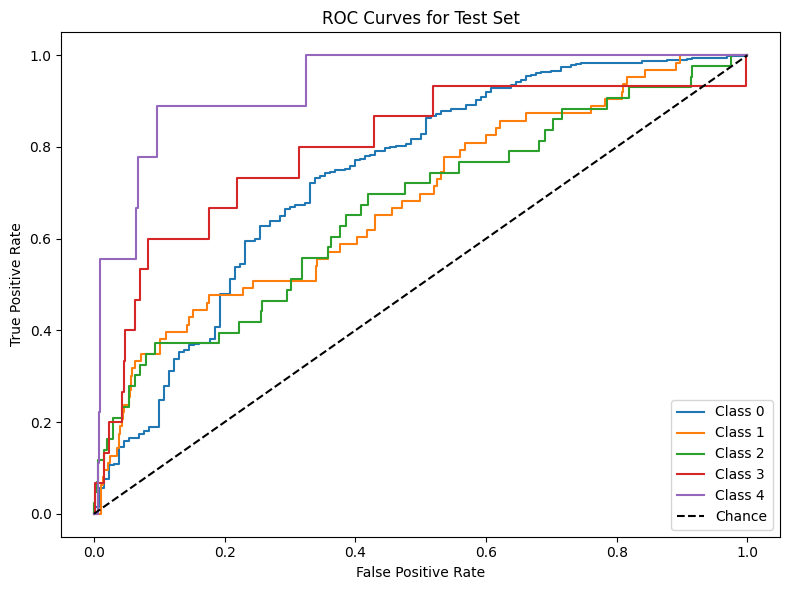


Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       544
           1       0.12      0.07      0.09        59
           2       0.15      0.12      0.13        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.76       668
   macro avg       0.22      0.22      0.22       668
weighted avg       0.70      0.76      0.73       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


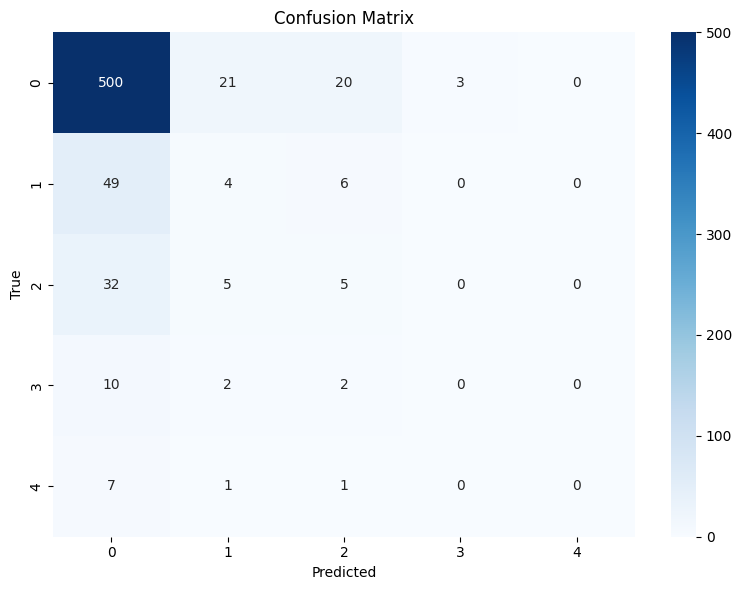


Test AUC (macro-average, OVR): 0.6601


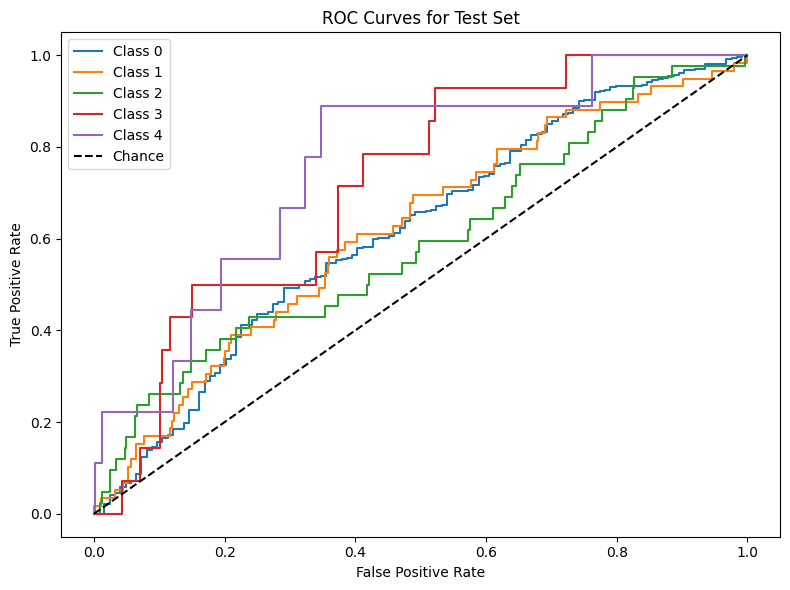


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       455
           1       0.26      0.37      0.30        52
           2       0.23      0.21      0.22        29
           3       1.00      0.10      0.18        10
           4       0.00      0.00      0.00         8

    accuracy                           0.77       554
   macro avg       0.47      0.31      0.32       554
weighted avg       0.77      0.77      0.76       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


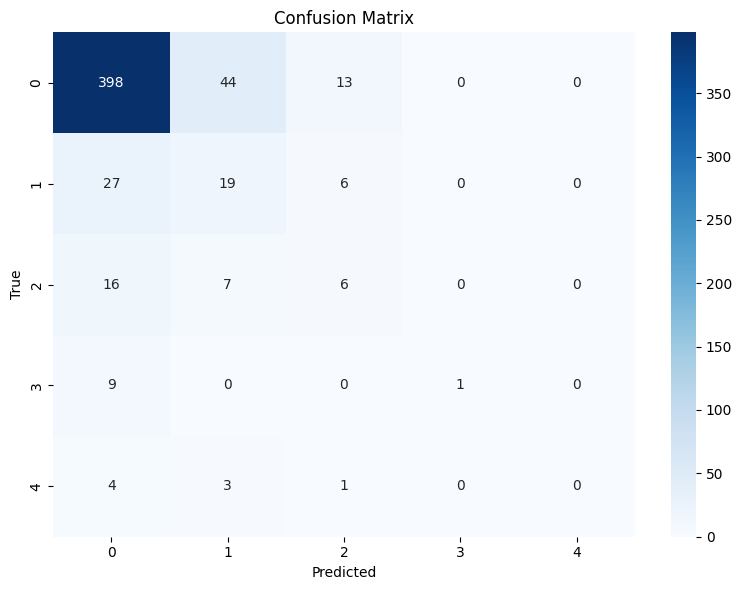


Test AUC (macro-average, OVR): 0.6989


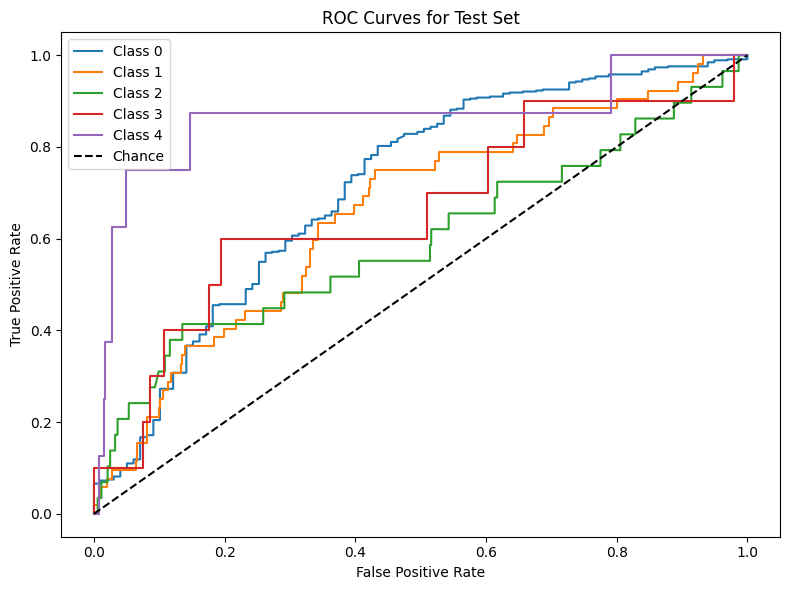


Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       395
           1       0.15      0.07      0.10        40
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.76       477
   macro avg       0.20      0.20      0.19       477
weighted avg       0.71      0.76      0.73       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


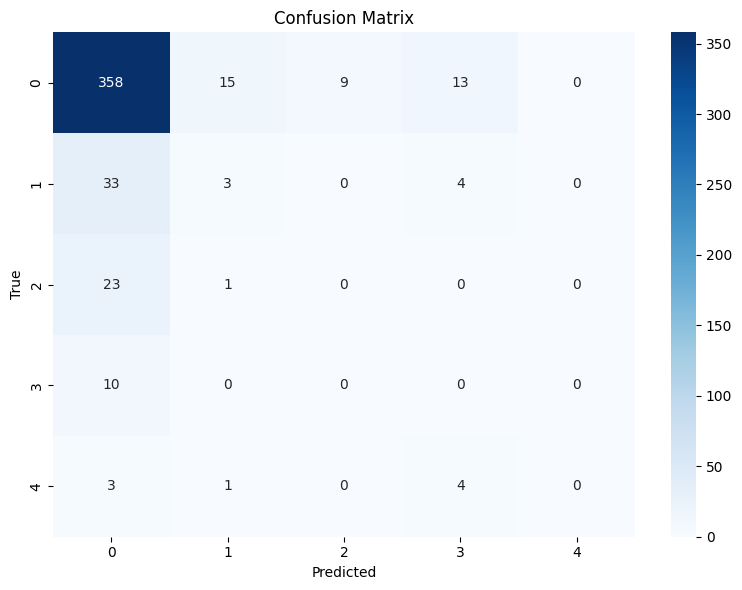


Test AUC (macro-average, OVR): 0.5819


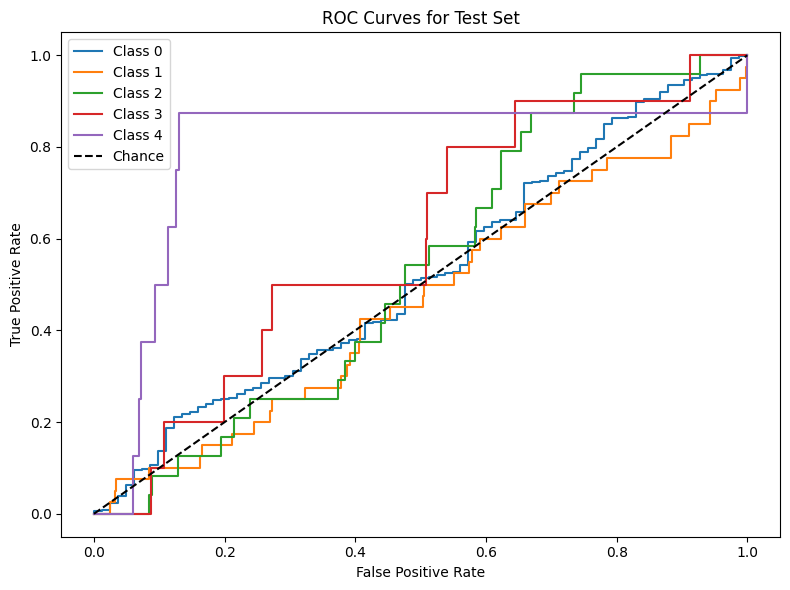

In [8]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-node-clustering/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Sample

In [9]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import LabelEncoder, label_binarize

def train_not_balance_phase(phase_path, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_fold = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled_np = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled_np = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled_np, columns=X_val.columns)

        # Encode target labels
        label_encoder = LabelEncoder()
        y_train_enc = label_encoder.fit_transform(y_train)
        y_val_enc = label_encoder.transform(y_val)
        class_names = label_encoder.classes_

        # Convert to NumPy arrays
        X_train_np = X_train_scaled.values
        X_val_np = X_val_scaled.values

        # Define and train TabNet model
        model = TabNetClassifier(
            seed=random_state,
            verbose=0
        )

        model.fit(
            X_train=X_train_np, y_train=y_train_enc,
            eval_set=[(X_train_np, y_train_enc), (X_val_np, y_val_enc)],
            eval_name=['train', 'val'],
            eval_metric=['accuracy'],
            max_epochs=100,
            patience=10,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0
        )

        # Plot training history
        history = model.history.history
        val_acc = history.get('val_accuracy', None)
        train_acc = history.get('train_accuracy', None)
        epochs = list(range(1, len(val_acc) + 1)) if val_acc else []
        
        if val_acc and train_acc:
            plt.figure(figsize=(6, 4))
            plt.plot(epochs, train_acc, label='Train Accuracy', marker='o', color='green')
            plt.plot(epochs, val_acc, label='Val Accuracy', marker='o', color='blue')
            plt.title(f'Fold {fold} - Balanced Accuracy per Epoch')
            plt.xlabel('Epoch')
            plt.ylabel('Balanced Accuracy')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

        # Evaluate
        y_pred_enc = model.predict(X_val_np)
        y_pred = label_encoder.inverse_transform(y_pred_enc)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        # AUC
        y_proba = model.predict_proba(X_val_np)
        y_val_bin = label_binarize(y_val_enc, classes=np.arange(len(class_names)))
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold
            best_label_encoder = label_encoder

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ROC Curves
        plt.figure(figsize=(8, 6))
        for i, class_label in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {class_label}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.title(f'Fold {fold} ROC Curves')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    # Feature Importances
    feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    print("\nFeature Importances:")
    print(feature_importances.head(10))

    return best_model, best_scaler, best_fold, all_metrics



=== Training Phase 1 ===

Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_accuracy = 0.6291


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


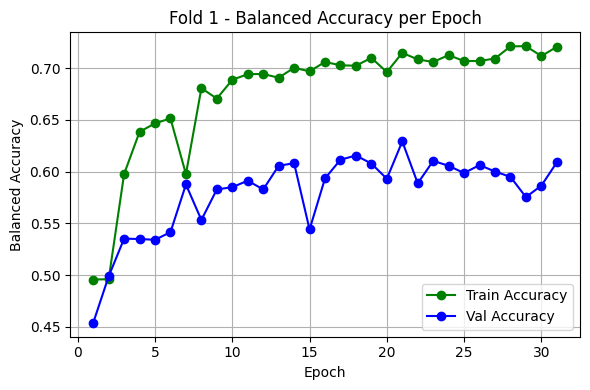


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.72      0.78      1785
           1       0.49      0.41      0.45       604
           2       0.31      0.53      0.39       258
           3       0.18      0.59      0.27        59
           4       0.03      0.11      0.04         9

    accuracy                           0.63      2715
   macro avg       0.37      0.47      0.39      2715
weighted avg       0.70      0.63      0.65      2715



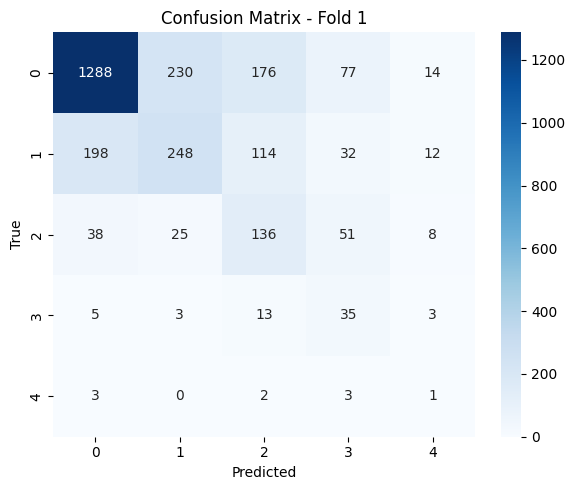

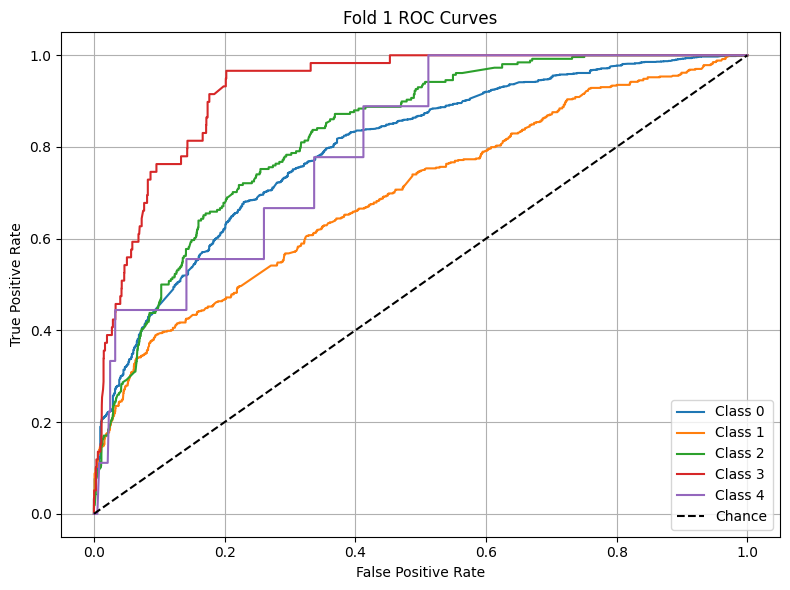


Early stopping occurred at epoch 57 with best_epoch = 47 and best_val_accuracy = 0.62712


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


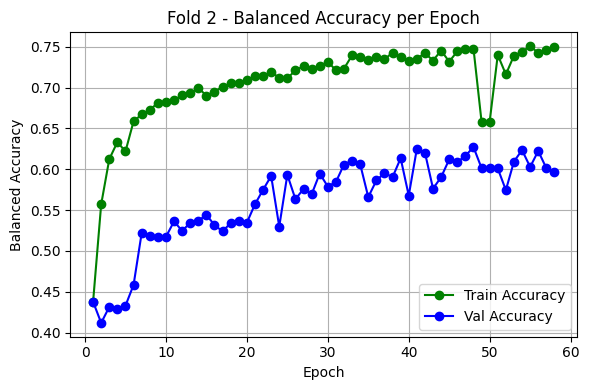


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.70      0.76      1786
           1       0.50      0.41      0.45       603
           2       0.33      0.61      0.43       258
           3       0.19      0.61      0.29        59
           4       0.03      0.12      0.05         8

    accuracy                           0.63      2714
   macro avg       0.38      0.49      0.40      2714
weighted avg       0.69      0.63      0.65      2714



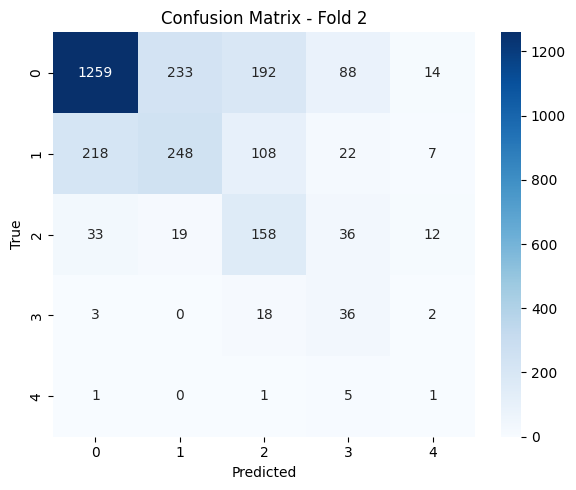

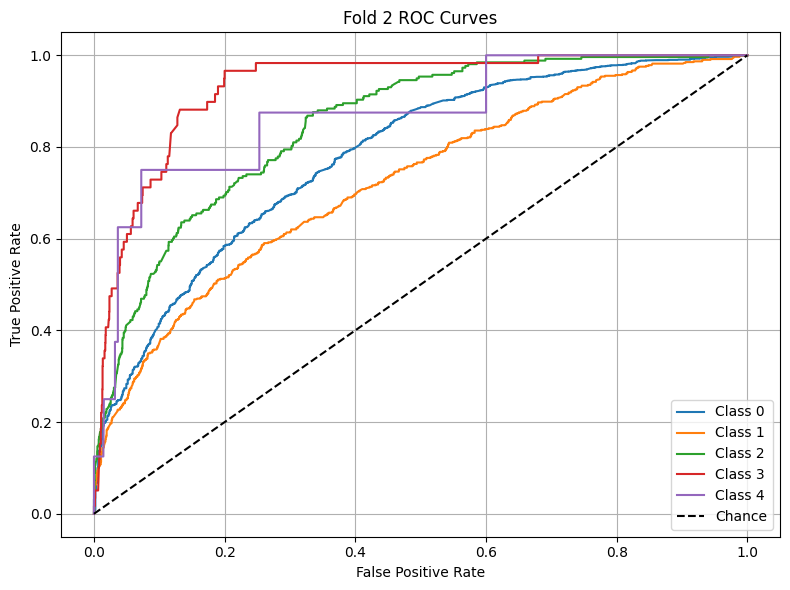


Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_accuracy = 0.5958


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


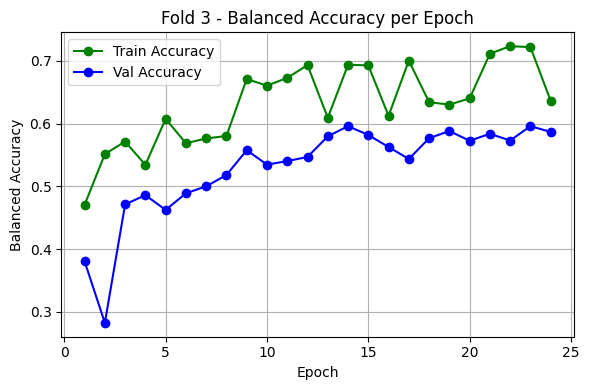


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.64      0.73      1786
           1       0.43      0.47      0.45       603
           2       0.30      0.62      0.41       258
           3       0.30      0.53      0.38        59
           4       0.04      0.38      0.07         8

    accuracy                           0.60      2714
   macro avg       0.38      0.53      0.41      2714
weighted avg       0.69      0.60      0.63      2714



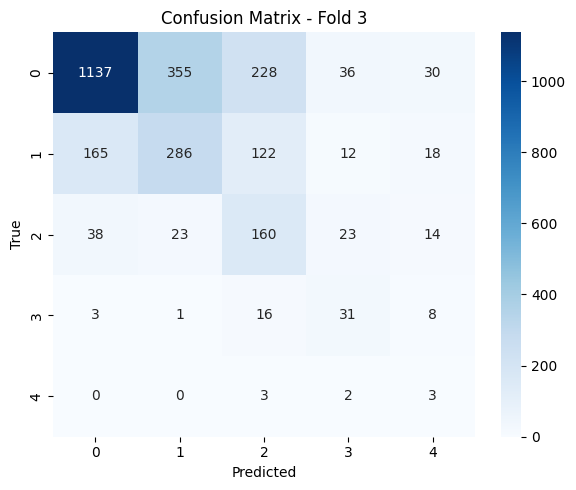

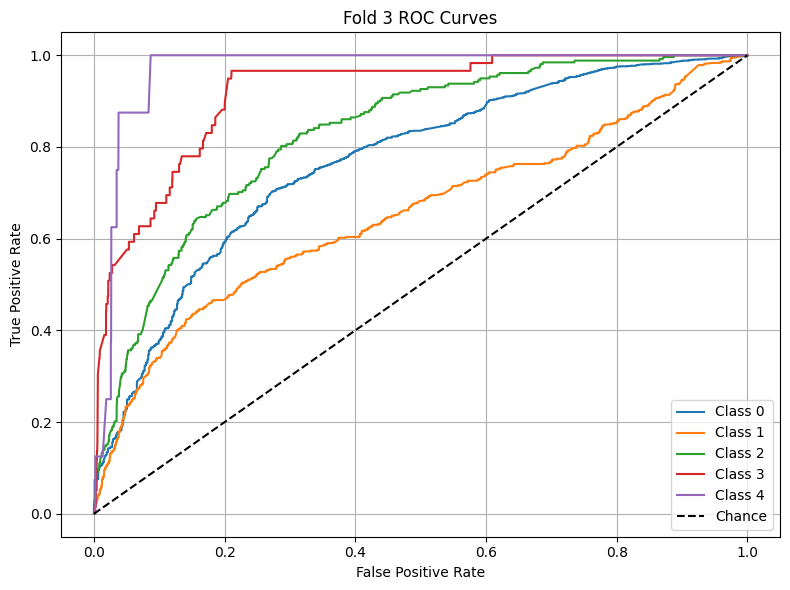


Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_accuracy = 0.65144


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


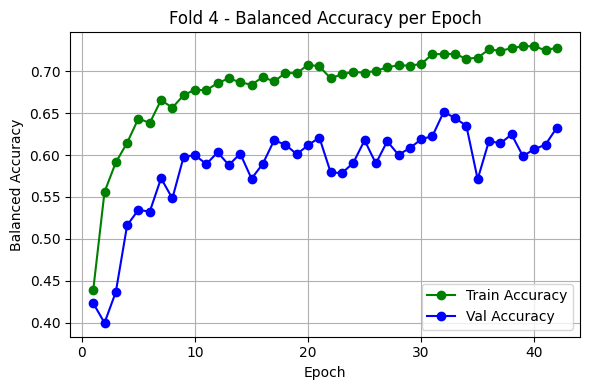


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.74      0.78      1785
           1       0.49      0.45      0.47       603
           2       0.35      0.58      0.44       258
           3       0.24      0.49      0.32        59
           4       0.12      0.22      0.15         9

    accuracy                           0.65      2714
   macro avg       0.40      0.50      0.43      2714
weighted avg       0.69      0.65      0.67      2714



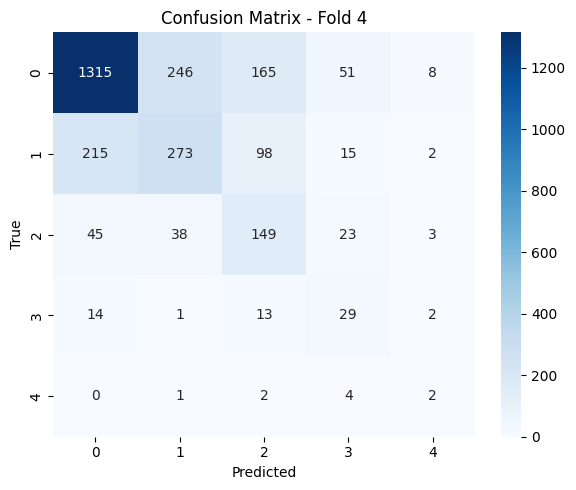

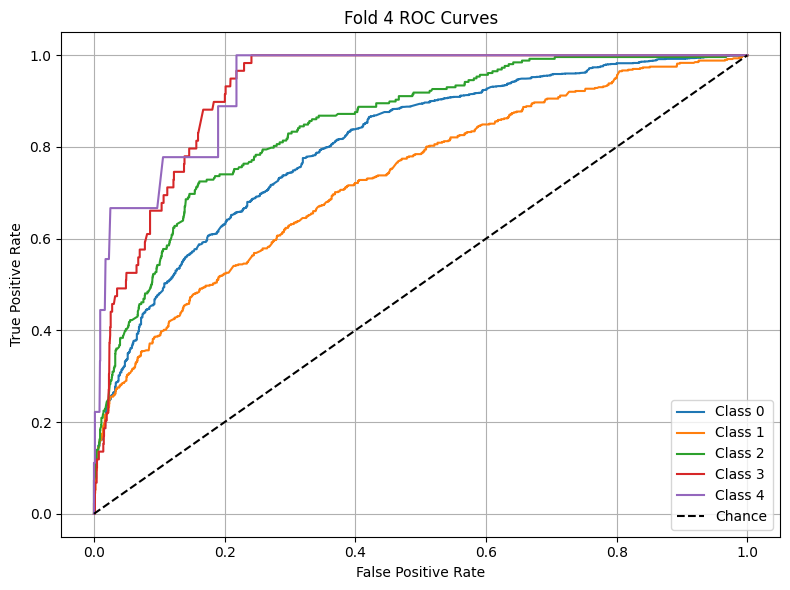


Early stopping occurred at epoch 53 with best_epoch = 43 and best_val_accuracy = 0.65844


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


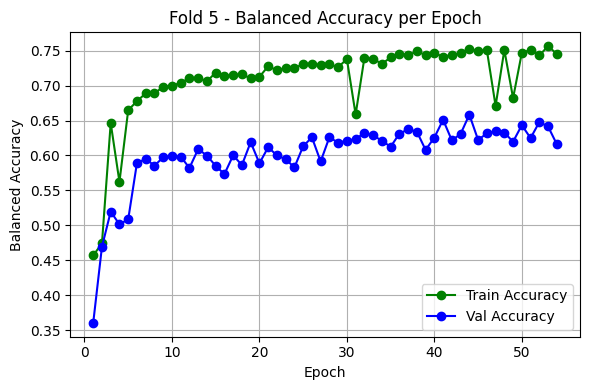


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.76      0.80      1785
           1       0.52      0.43      0.47       603
           2       0.37      0.48      0.42       258
           3       0.17      0.53      0.25        59
           4       0.11      0.67      0.19         9

    accuracy                           0.66      2714
   macro avg       0.40      0.57      0.43      2714
weighted avg       0.70      0.66      0.68      2714



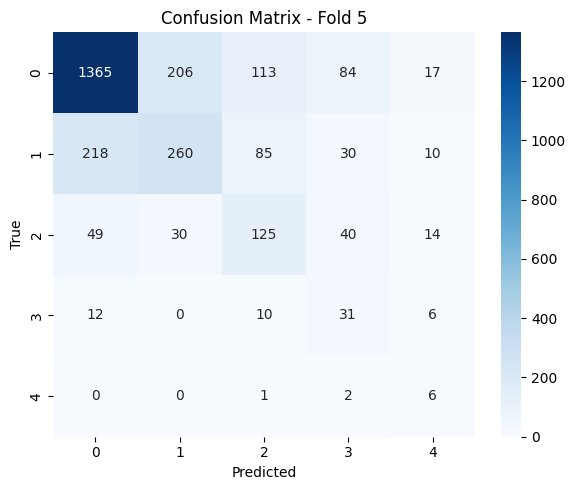

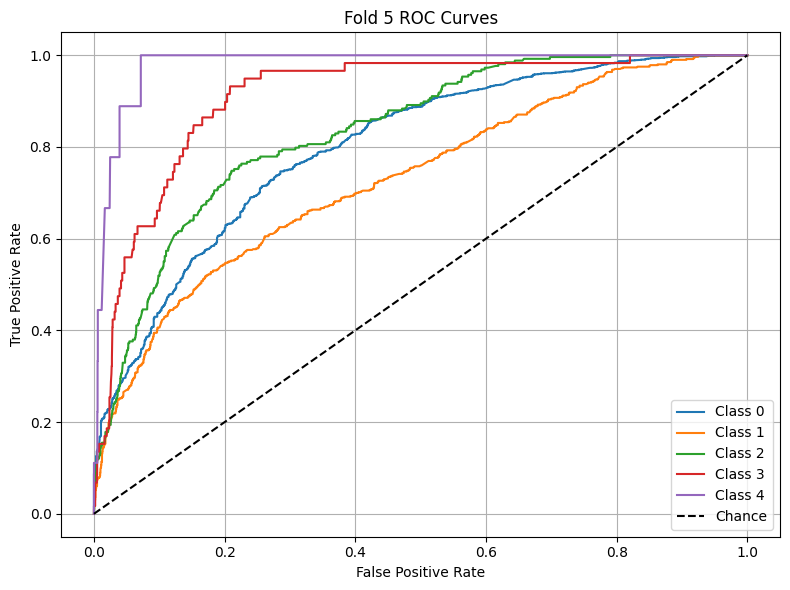


Average Accuracy: 0.6324
Average F1 Macro: 0.4097
Average AUC: 0.8337

Feature Importances:
assignment                             0.282745
user_month                             0.155400
video_count                            0.083557
exercise_perc_real_completed_mean_1    0.060697
num_prerequisites                      0.048268
video                                  0.044810
school                                 0.036490
exercise_count                         0.032870
exercise_context_sum_1                 0.029318
exercise_hour_entropy_1                0.028612
dtype: float64

=== Training Phase 2 ===

Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_accuracy = 0.61991


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


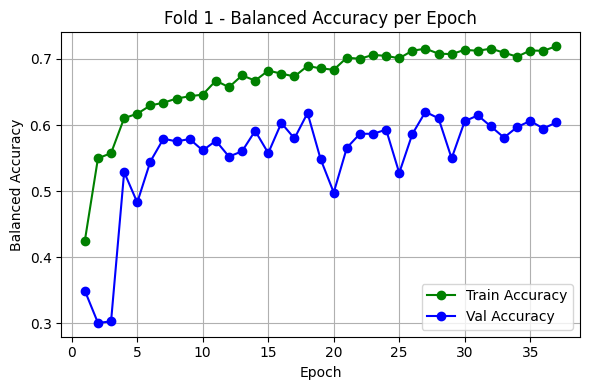


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.69      0.76      1489
           1       0.44      0.45      0.44       488
           2       0.33      0.53      0.41       220
           3       0.19      0.52      0.28        54
           4       0.08      0.44      0.14         9

    accuracy                           0.62      2260
   macro avg       0.38      0.53      0.41      2260
weighted avg       0.69      0.62      0.65      2260



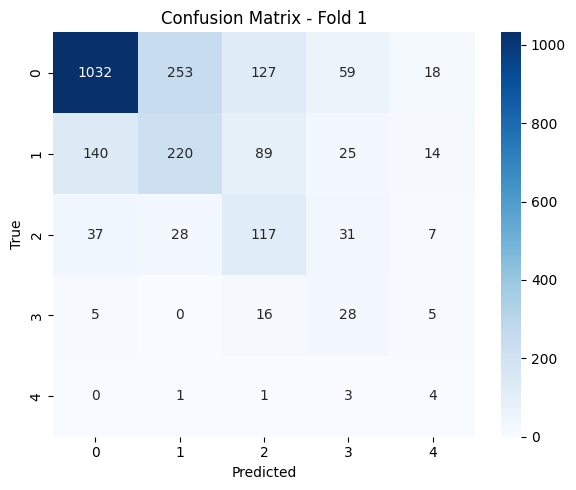

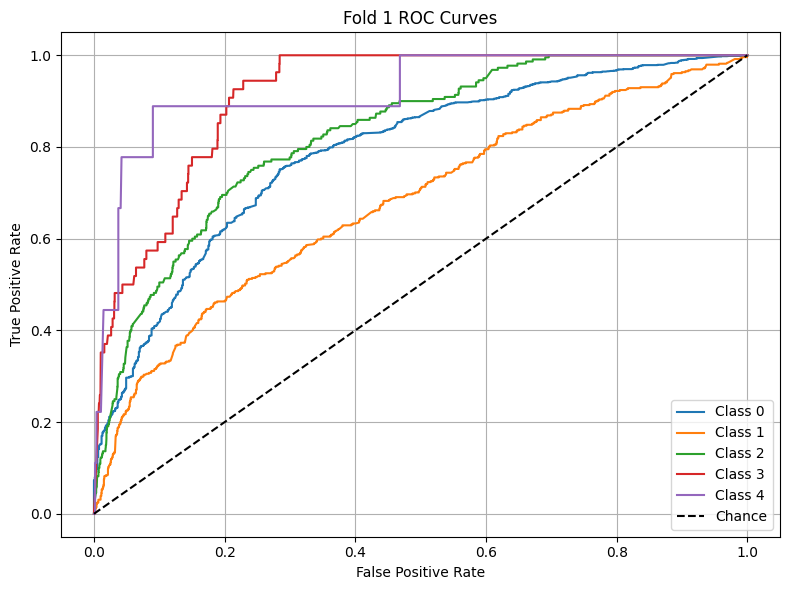


Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_accuracy = 0.61195


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


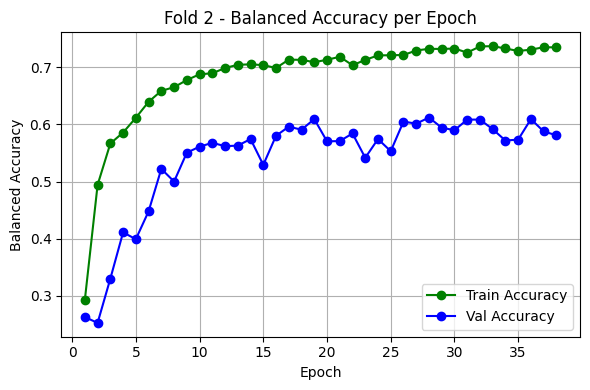


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.69      0.75      1489
           1       0.42      0.46      0.44       489
           2       0.33      0.45      0.38       219
           3       0.20      0.58      0.29        55
           4       0.14      0.62      0.23         8

    accuracy                           0.61      2260
   macro avg       0.38      0.56      0.42      2260
weighted avg       0.68      0.61      0.64      2260



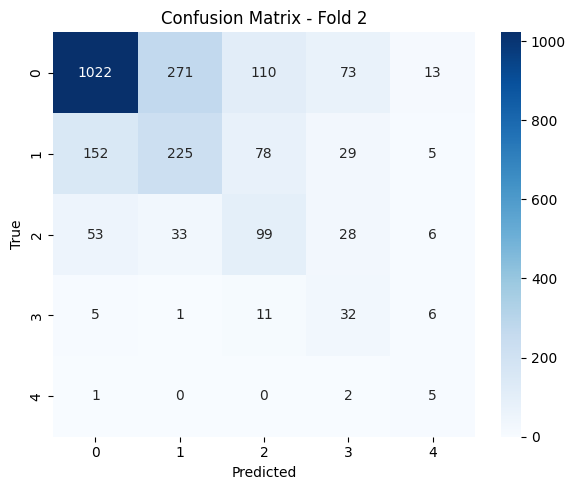

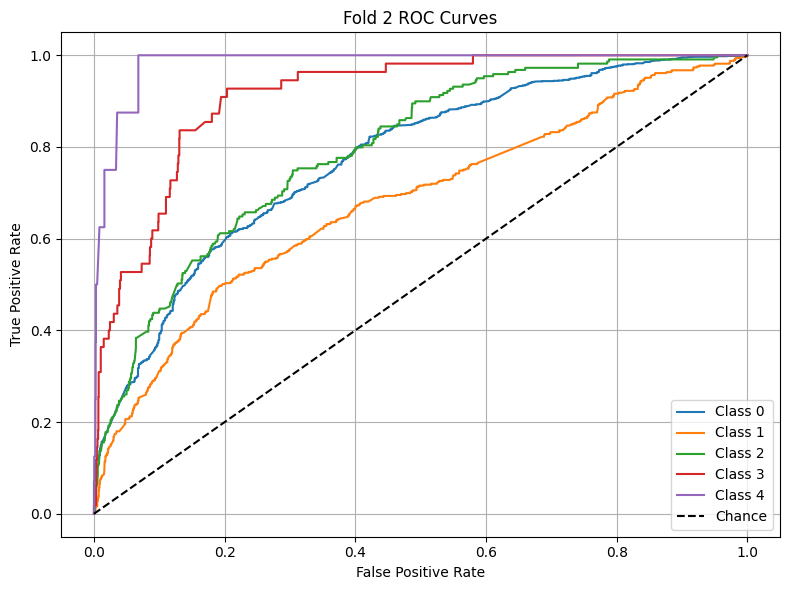


Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_accuracy = 0.61532


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


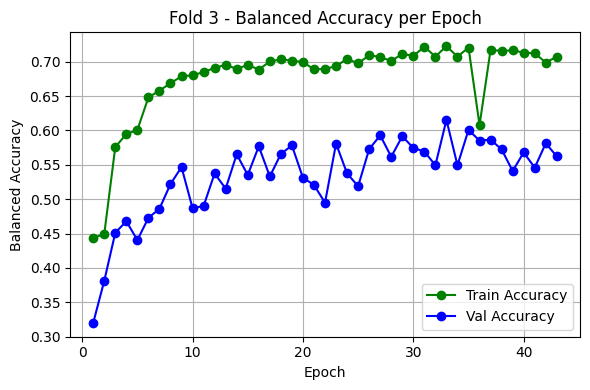


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77      1489
           1       0.43      0.37      0.39       489
           2       0.31      0.52      0.39       219
           3       0.18      0.52      0.27        54
           4       0.14      0.62      0.23         8

    accuracy                           0.62      2259
   macro avg       0.38      0.55      0.41      2259
weighted avg       0.67      0.62      0.64      2259



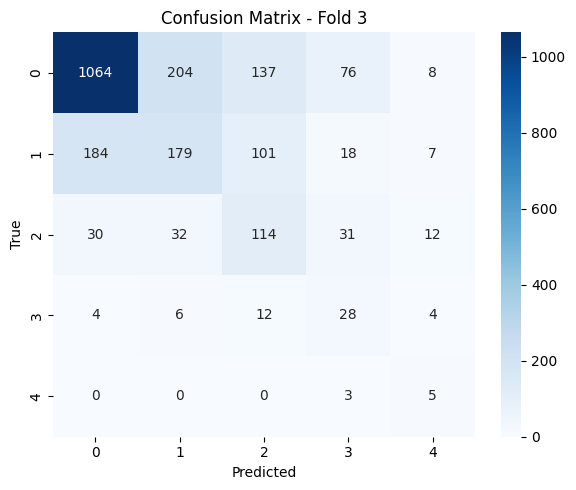

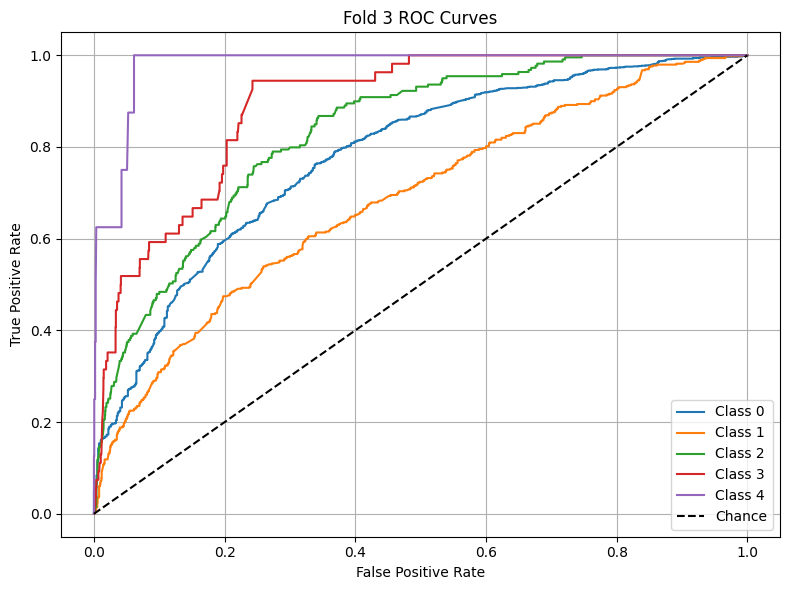


Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_accuracy = 0.61355


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


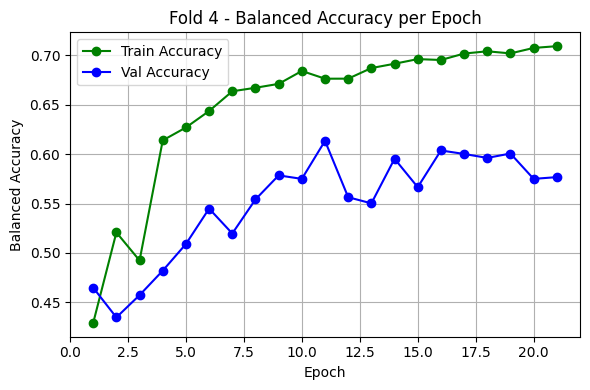


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.71      0.75      1489
           1       0.47      0.38      0.42       489
           2       0.33      0.44      0.38       219
           3       0.24      0.74      0.36        54
           4       0.06      0.62      0.11         8

    accuracy                           0.61      2259
   macro avg       0.38      0.58      0.40      2259
weighted avg       0.67      0.61      0.63      2259



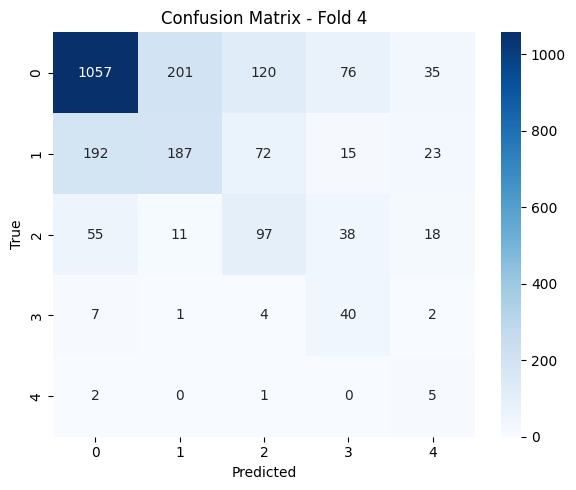

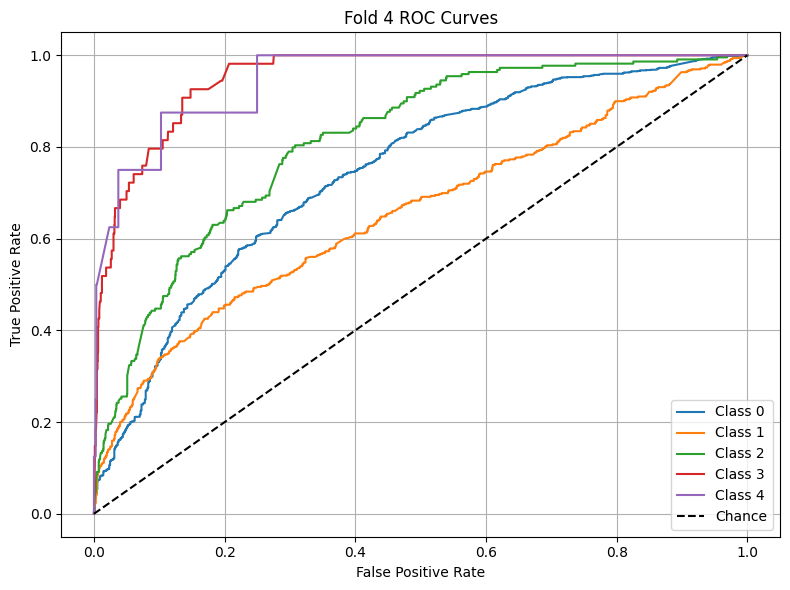


Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_accuracy = 0.59628


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


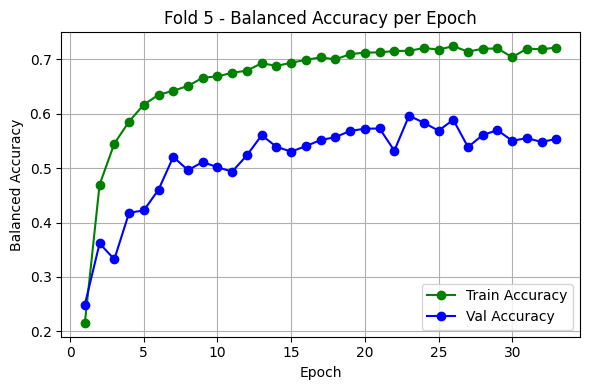


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.68      0.75      1490
           1       0.45      0.39      0.42       488
           2       0.32      0.55      0.41       219
           3       0.12      0.44      0.18        54
           4       0.10      0.50      0.16         8

    accuracy                           0.60      2259
   macro avg       0.36      0.51      0.38      2259
weighted avg       0.68      0.60      0.63      2259



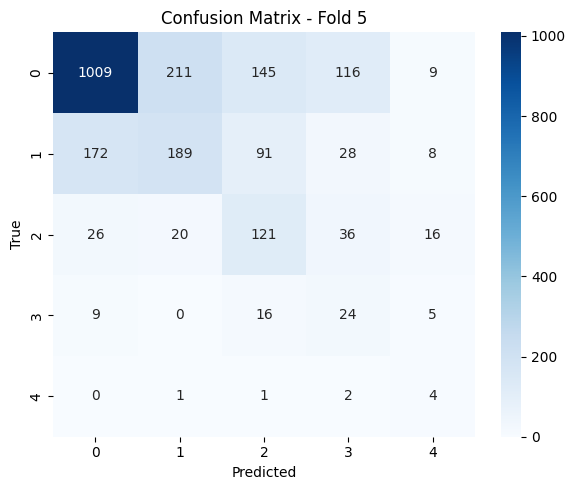

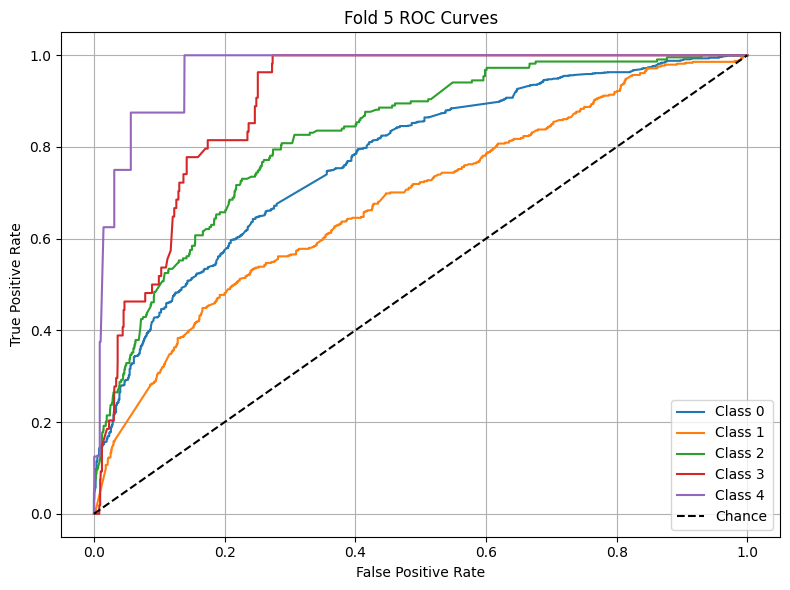


Average Accuracy: 0.6114
Average F1 Macro: 0.4049
Average AUC: 0.8276

Feature Importances:
video                               0.318572
duration_days                       0.108194
total_neutral2                      0.064499
user_month                          0.051326
exercise_correct_sum_1              0.048052
entropy_time_comment_phase1         0.047700
encoded_field_sum                   0.037381
closeness                           0.031430
exercise_langugage_binary_mean_2    0.027740
exercise_num_problem_sum_1          0.026990
dtype: float64

=== Training Phase 3 ===

Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_accuracy = 0.6215


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


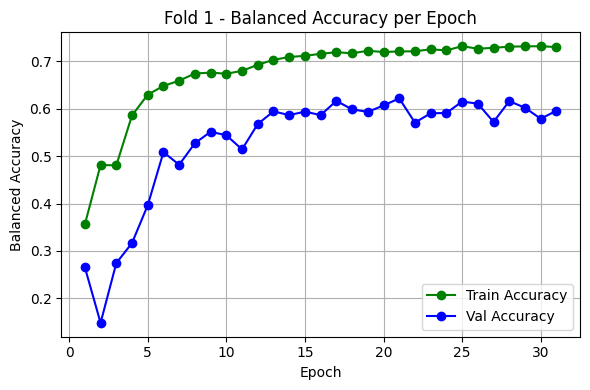


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.72      0.77      1361
           1       0.46      0.39      0.42       459
           2       0.33      0.51      0.40       198
           3       0.15      0.43      0.22        49
           4       0.10      0.57      0.17         7

    accuracy                           0.62      2074
   macro avg       0.37      0.52      0.40      2074
weighted avg       0.68      0.62      0.64      2074



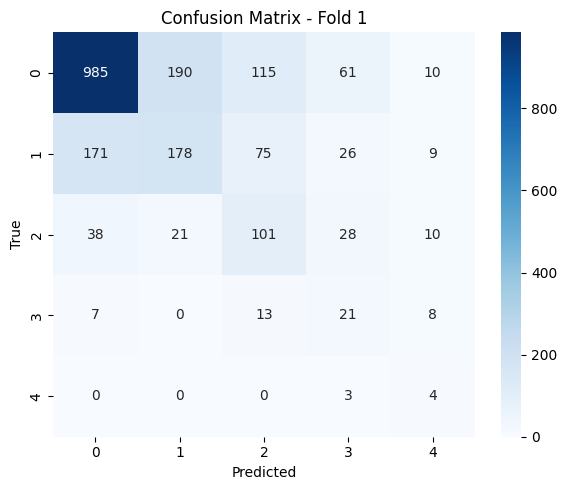

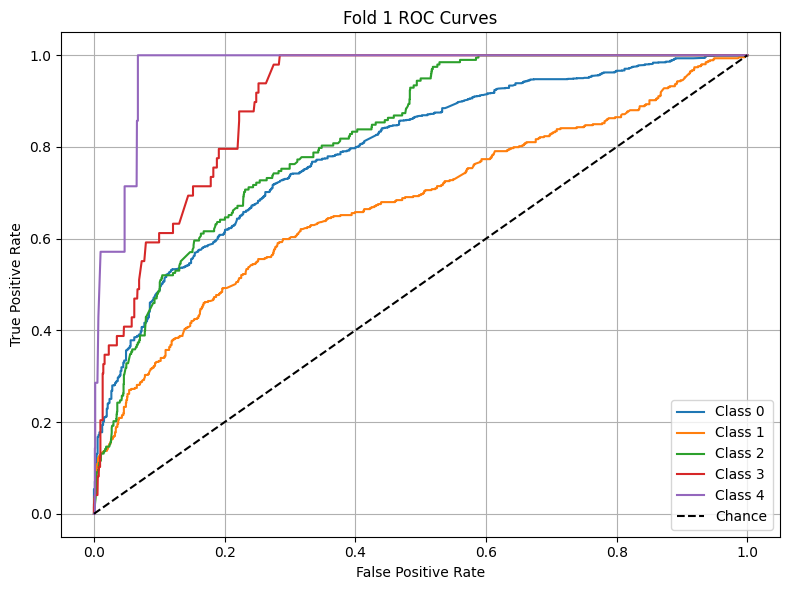


Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_accuracy = 0.59932


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


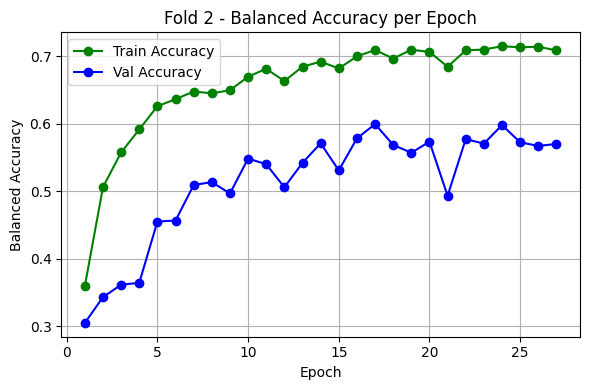


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.70      0.75      1360
           1       0.44      0.38      0.40       459
           2       0.32      0.45      0.37       198
           3       0.18      0.64      0.28        50
           4       0.06      0.43      0.10         7

    accuracy                           0.60      2074
   macro avg       0.36      0.52      0.38      2074
weighted avg       0.67      0.60      0.62      2074



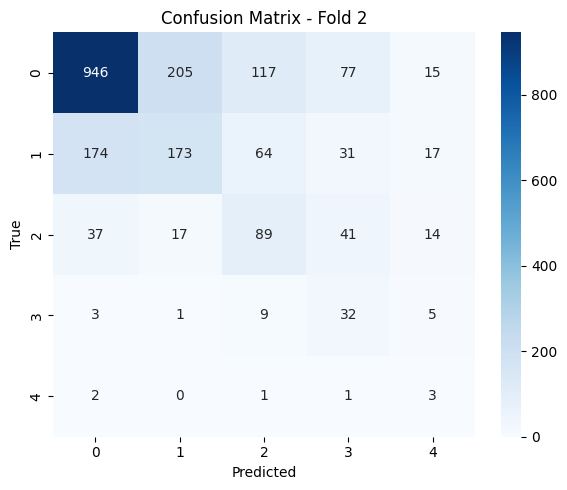

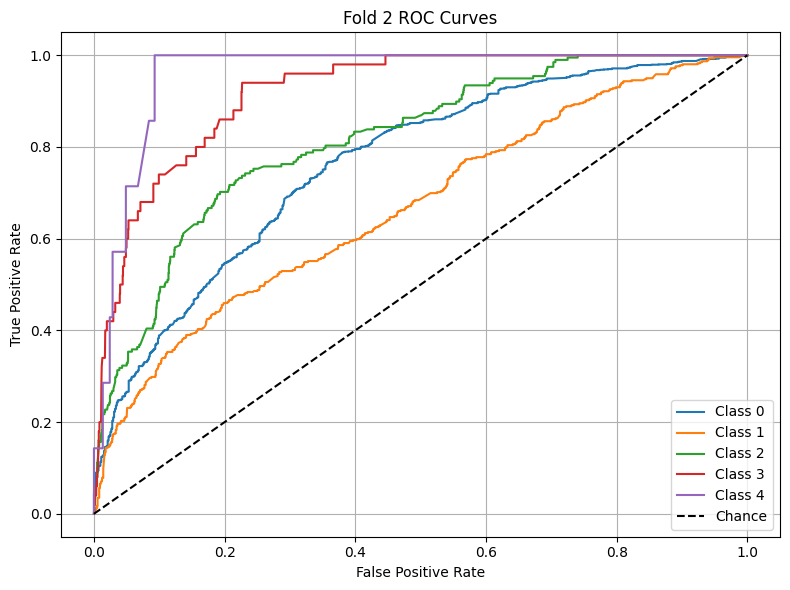


Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_accuracy = 0.59499


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


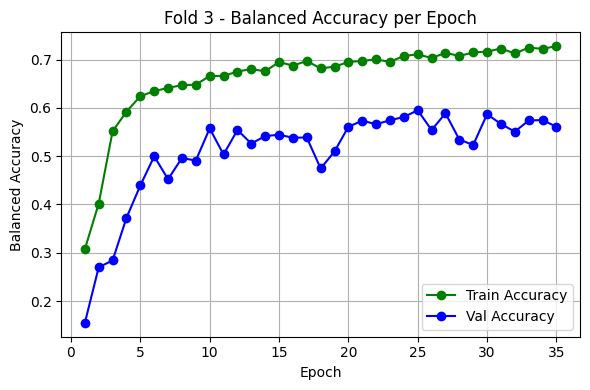


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.70      0.75      1360
           1       0.46      0.32      0.38       459
           2       0.30      0.54      0.38       198
           3       0.17      0.64      0.27        50
           4       0.09      0.43      0.14         7

    accuracy                           0.59      2074
   macro avg       0.36      0.52      0.38      2074
weighted avg       0.66      0.59      0.62      2074



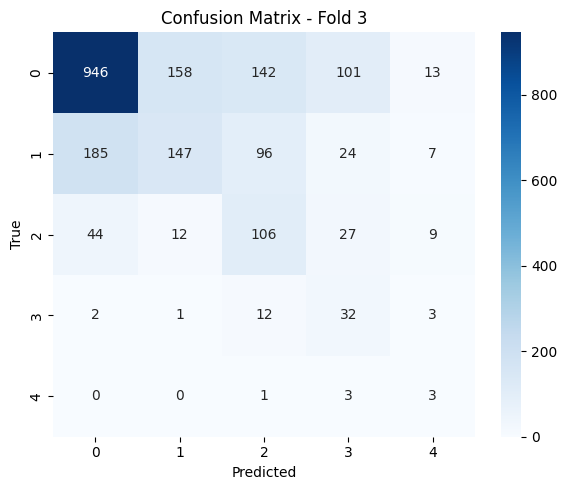

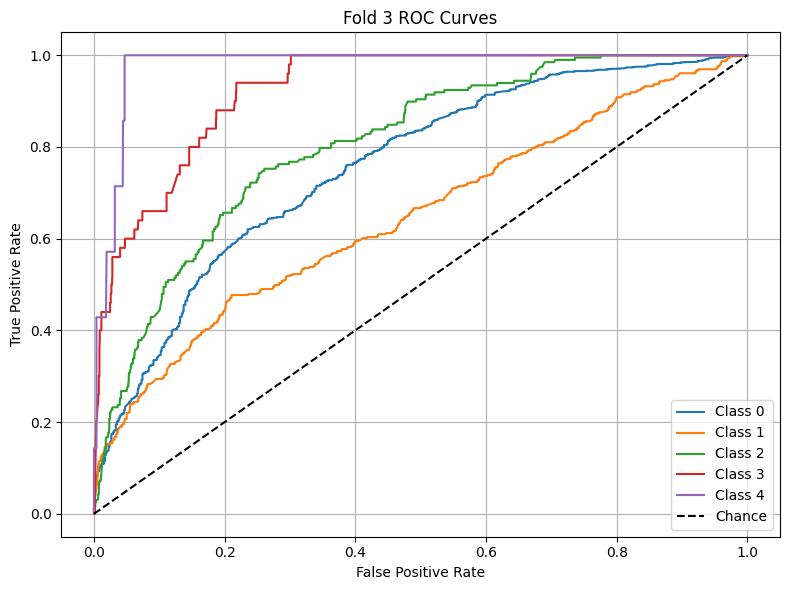


Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_accuracy = 0.62488


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


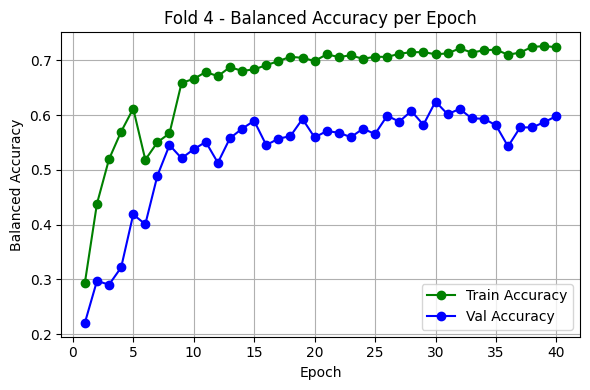


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.72      0.76      1360
           1       0.47      0.43      0.45       459
           2       0.30      0.43      0.36       198
           3       0.28      0.58      0.37        50
           4       0.08      0.57      0.14         7

    accuracy                           0.62      2074
   macro avg       0.39      0.55      0.42      2074
weighted avg       0.67      0.62      0.64      2074



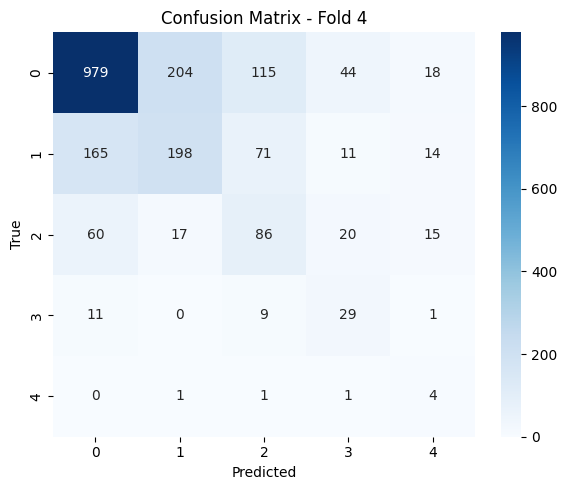

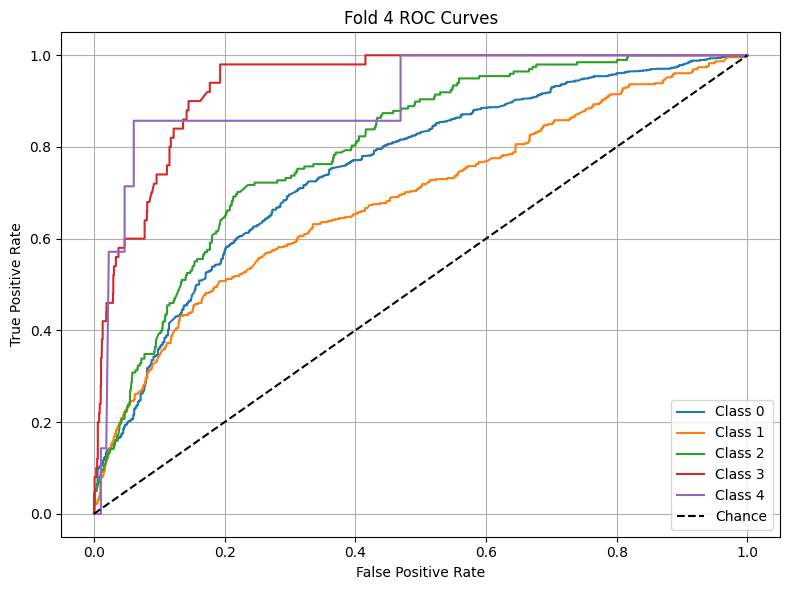


Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_accuracy = 0.61071


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


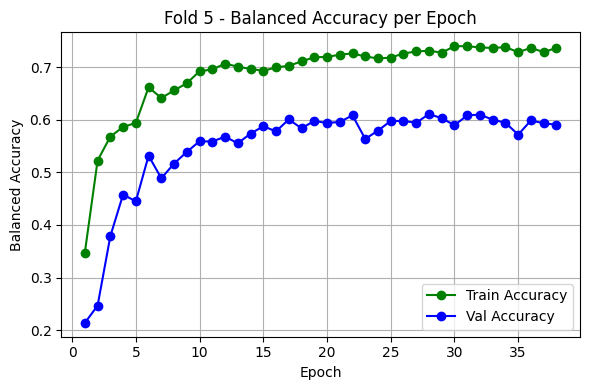


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.68      0.74      1360
           1       0.43      0.50      0.46       460
           2       0.35      0.47      0.40       197
           3       0.19      0.47      0.27        49
           4       0.06      0.29      0.11         7

    accuracy                           0.61      2073
   macro avg       0.37      0.48      0.40      2073
weighted avg       0.67      0.61      0.63      2073



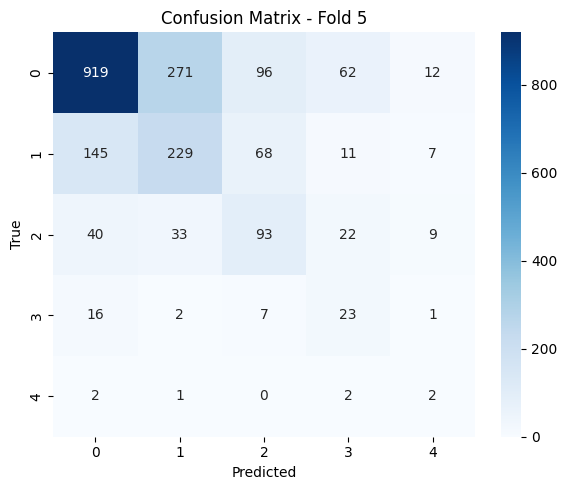

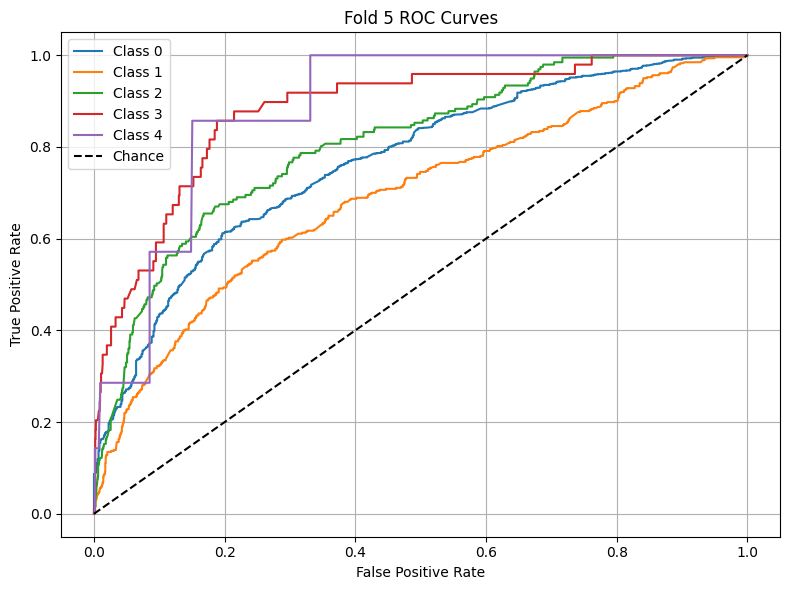


Average Accuracy: 0.6103
Average F1 Macro: 0.3945
Average AUC: 0.8209

Feature Importances:
assignment                     0.206594
degree                         0.092749
cluster                        0.092540
total_neutral1                 0.059905
user_month                     0.047396
entropy_time_comment_phase1    0.046682
exercise_hour_entropy_2        0.044924
chapter_count                  0.038738
total_positive3                0.037429
duration_days                  0.037111
dtype: float64

=== Training Phase 4 ===

Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_accuracy = 0.58155


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


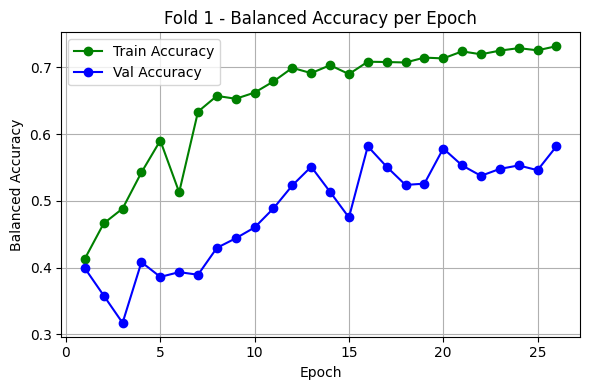


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73      1000
           1       0.45      0.44      0.44       355
           2       0.23      0.35      0.28       139
           3       0.18      0.51      0.26        39
           4       0.11      0.67      0.19         6

    accuracy                           0.58      1539
   macro avg       0.35      0.53      0.38      1539
weighted avg       0.65      0.58      0.61      1539



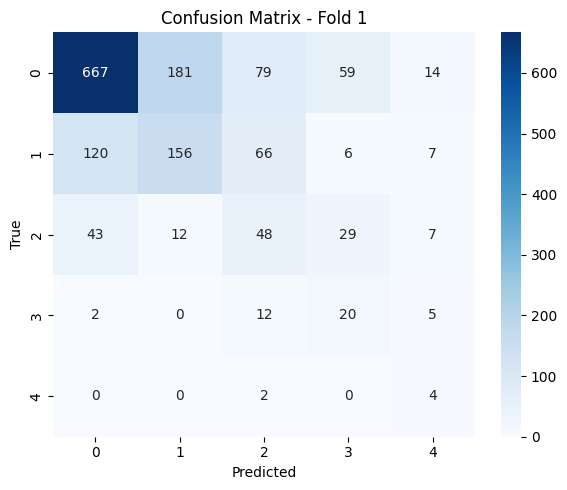

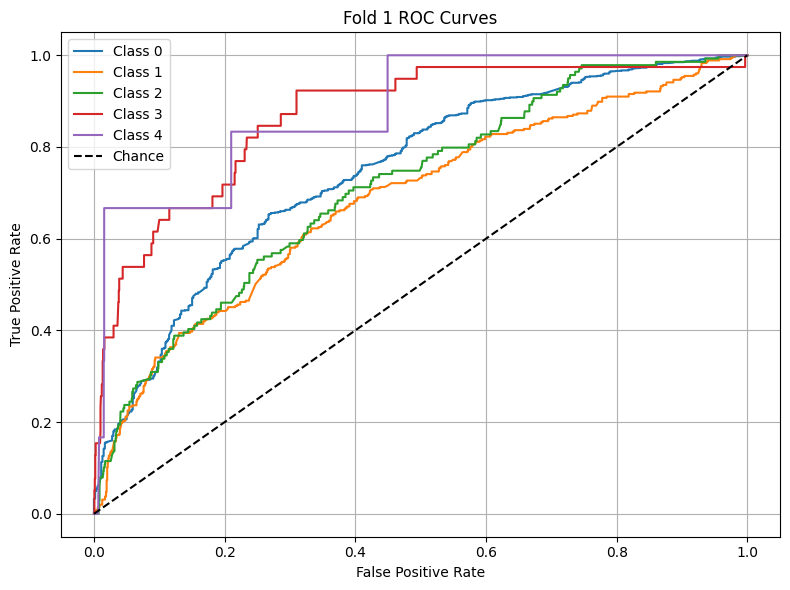


Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_accuracy = 0.63158


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


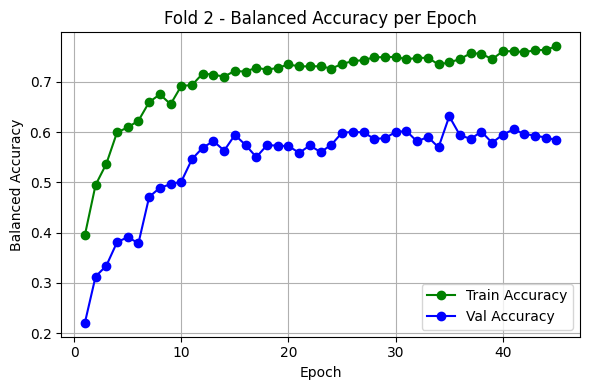


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.73      0.76      1000
           1       0.45      0.41      0.43       355
           2       0.43      0.49      0.46       139
           3       0.25      0.62      0.35        40
           4       0.06      0.40      0.10         5

    accuracy                           0.63      1539
   macro avg       0.40      0.53      0.42      1539
weighted avg       0.66      0.63      0.64      1539



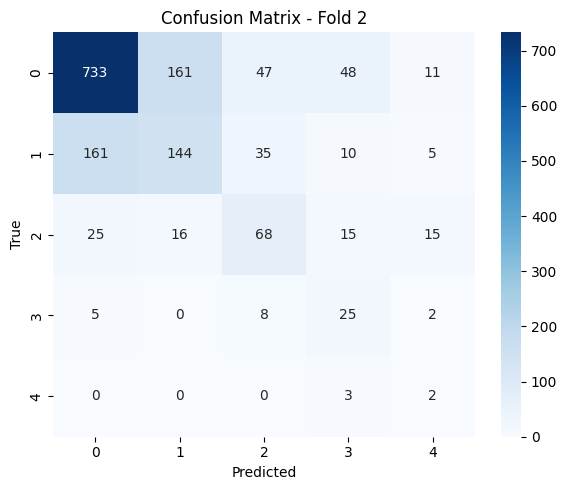

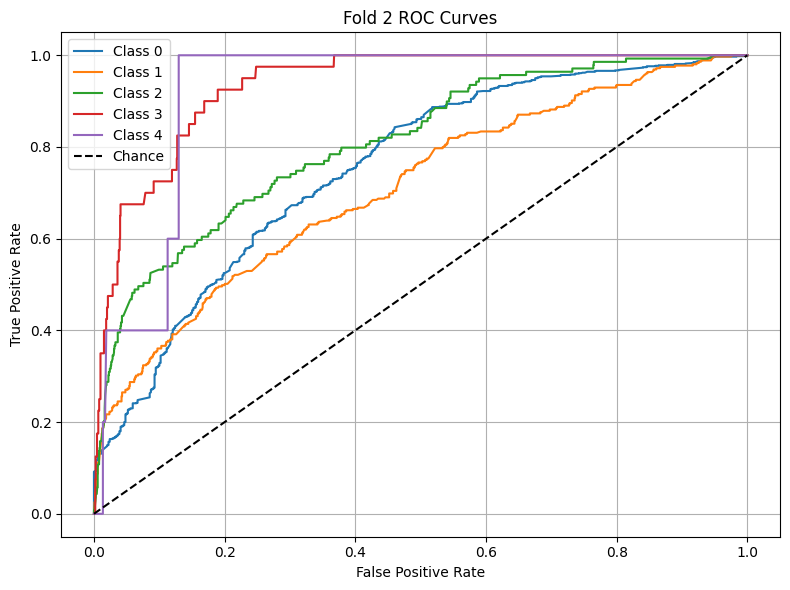


Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_accuracy = 0.63548


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


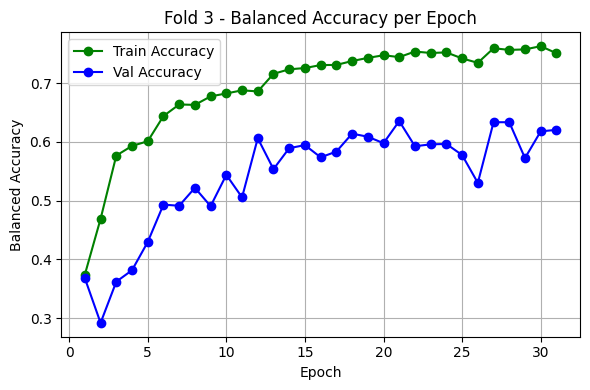


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.73      0.77       999
           1       0.50      0.42      0.45       355
           2       0.32      0.58      0.41       139
           3       0.22      0.42      0.29        40
           4       0.06      0.17      0.09         6

    accuracy                           0.64      1539
   macro avg       0.38      0.46      0.40      1539
weighted avg       0.68      0.64      0.65      1539



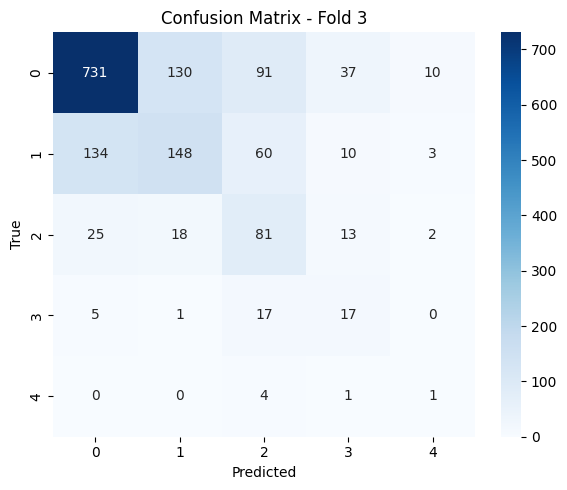

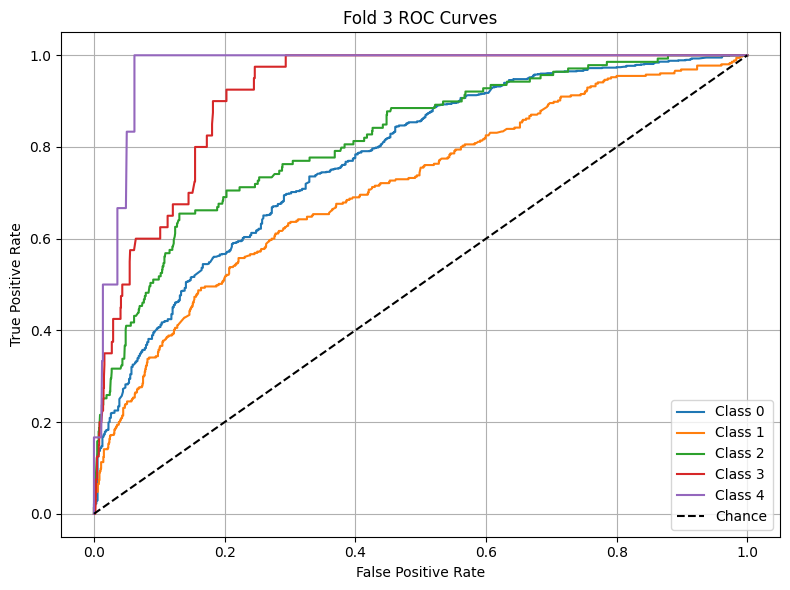


Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_accuracy = 0.61704


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


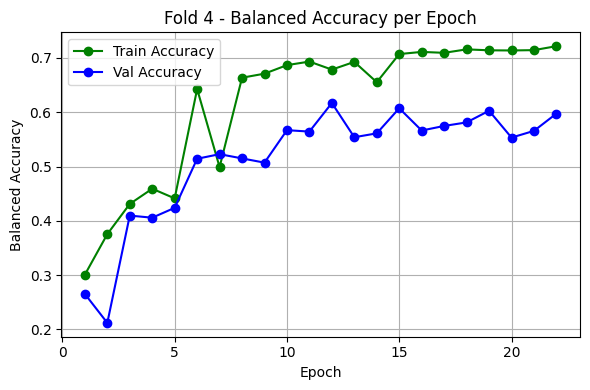


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.77      0.77       999
           1       0.53      0.24      0.33       356
           2       0.30      0.51      0.38       138
           3       0.22      0.54      0.32        39
           4       0.07      0.67      0.12         6

    accuracy                           0.62      1538
   macro avg       0.38      0.54      0.38      1538
weighted avg       0.66      0.62      0.62      1538



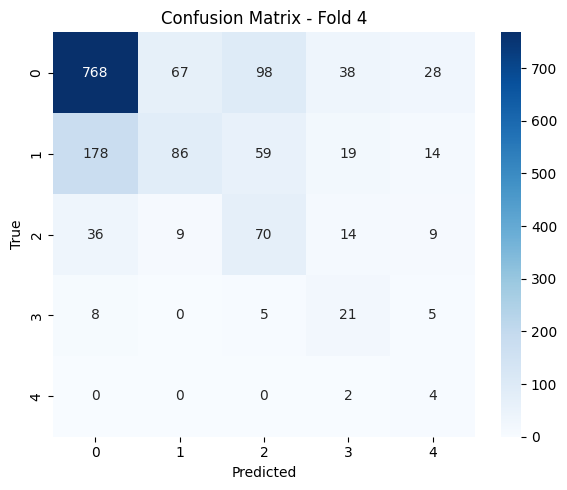

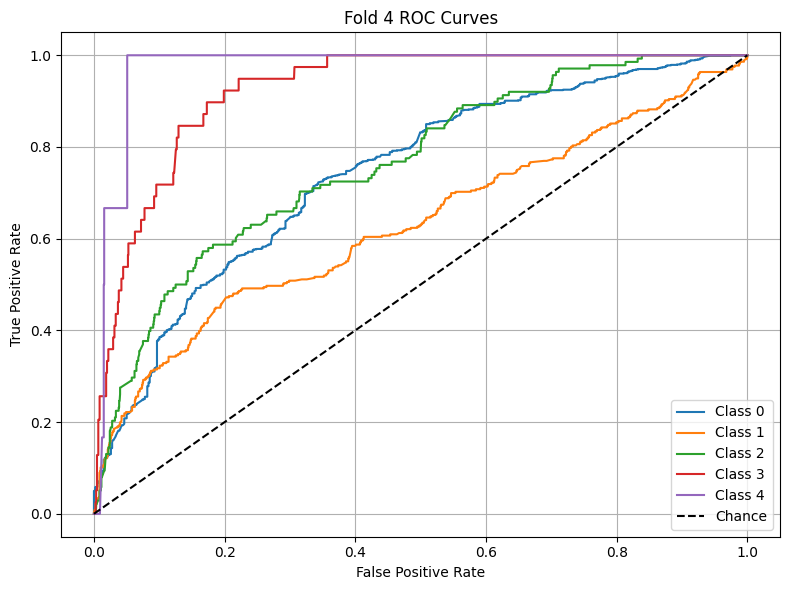


Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_accuracy = 0.65215


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


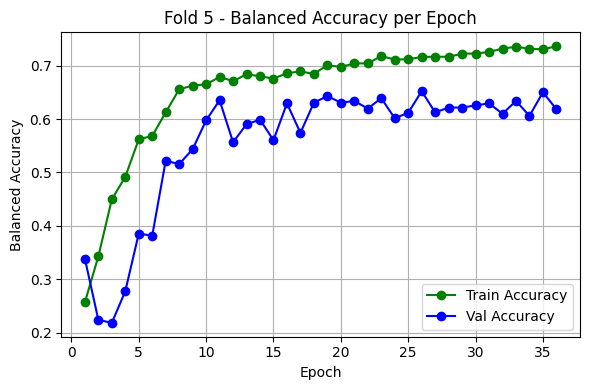


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.78       999
           1       0.49      0.50      0.50       356
           2       0.35      0.38      0.36       138
           3       0.29      0.64      0.40        39
           4       0.03      0.17      0.05         6

    accuracy                           0.65      1538
   macro avg       0.40      0.49      0.42      1538
weighted avg       0.69      0.65      0.67      1538



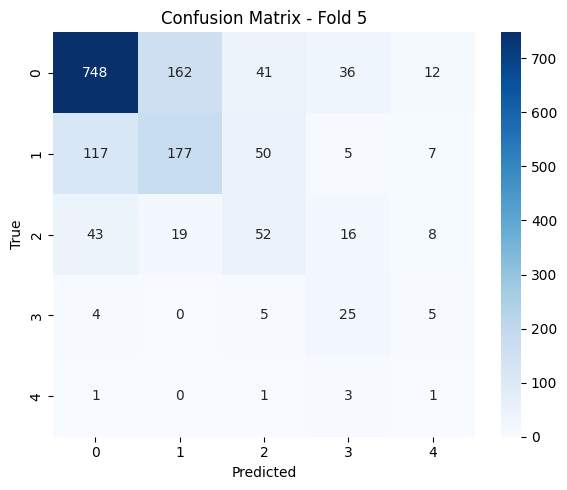

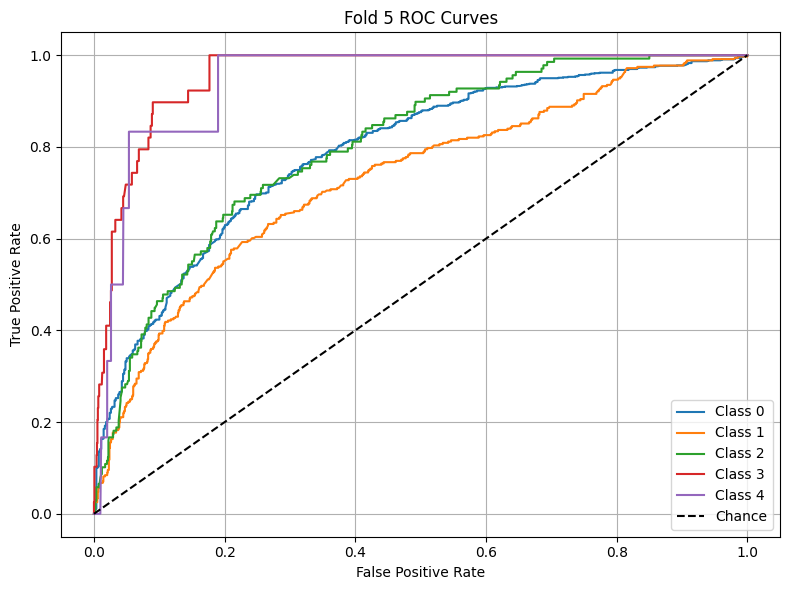


Average Accuracy: 0.6236
Average F1 Macro: 0.4012
Average AUC: 0.8185

Feature Importances:
encoded_field_sum               0.289049
assignment                      0.262910
exercise_count                  0.084316
video                           0.070225
video_pause_count_3             0.042556
video_speed_avg_1               0.031425
closeness                       0.029300
exercise_correct_mean_1         0.022032
exercise_attempts_sum_mean_4    0.019913
exercise_num_problem_sum_4      0.019827
dtype: float64


In [10]:
phase_paths = [f"/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_not_balance_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics



Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.67      0.76       568
           1       0.15      0.30      0.20        63
           2       0.13      0.30      0.18        43
           3       0.09      0.20      0.12        15
           4       0.00      0.00      0.00         9

    accuracy                           0.60       698
   macro avg       0.25      0.30      0.25       698
weighted avg       0.74      0.60      0.65       698



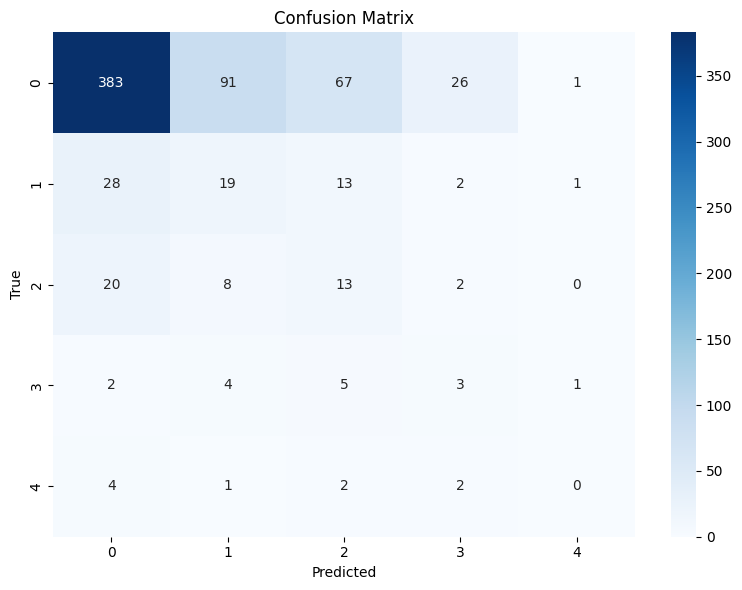


Test AUC (macro-average, OVR): 0.7099


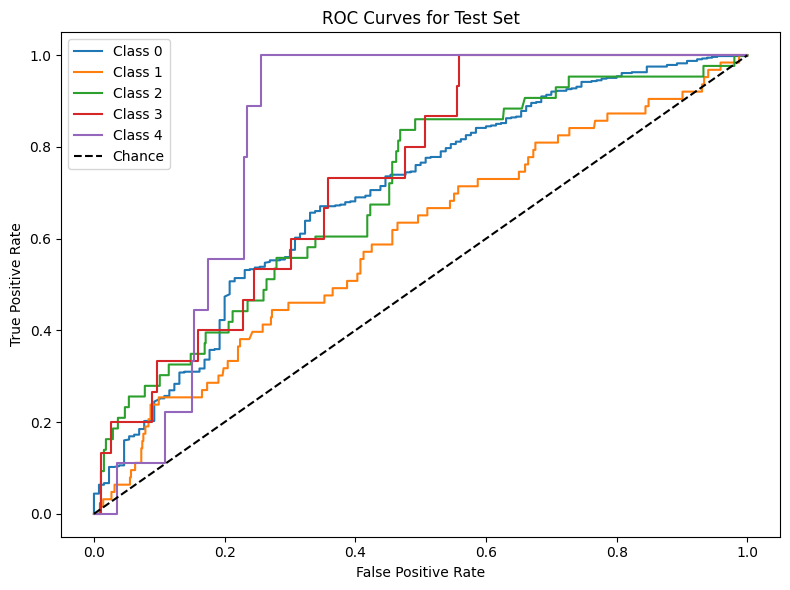


Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.59      0.71       544
           1       0.11      0.29      0.16        59
           2       0.15      0.40      0.22        42
           3       0.00      0.00      0.00        14
           4       0.11      0.22      0.14         9

    accuracy                           0.54       668
   macro avg       0.25      0.30      0.25       668
weighted avg       0.75      0.54      0.61       668



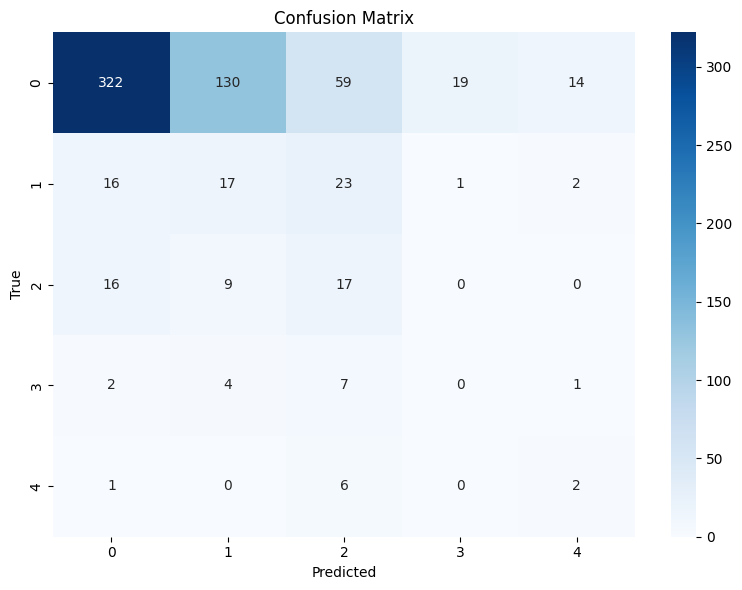


Test AUC (macro-average, OVR): 0.7066


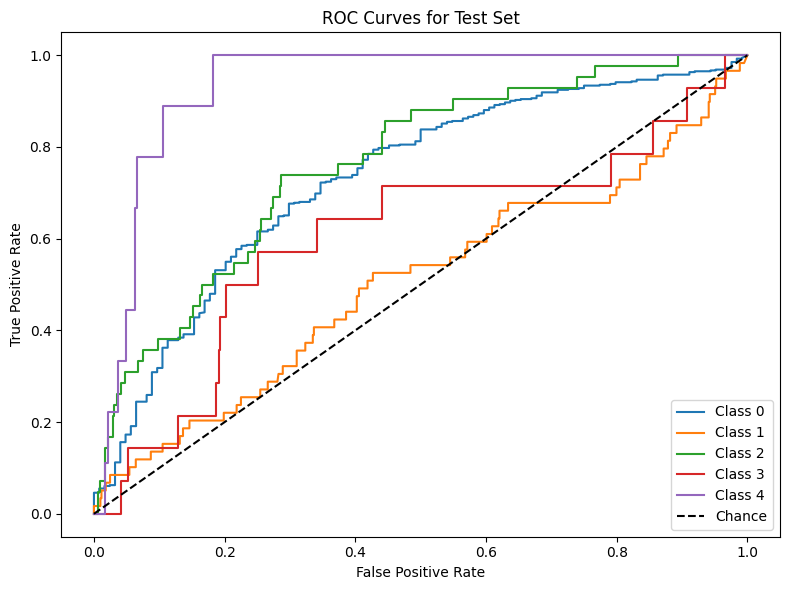


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.51      0.65       455
           1       0.13      0.46      0.21        52
           2       0.08      0.28      0.13        29
           3       0.08      0.10      0.09        10
           4       0.00      0.00      0.00         8

    accuracy                           0.48       554
   macro avg       0.24      0.27      0.22       554
weighted avg       0.74      0.48      0.56       554



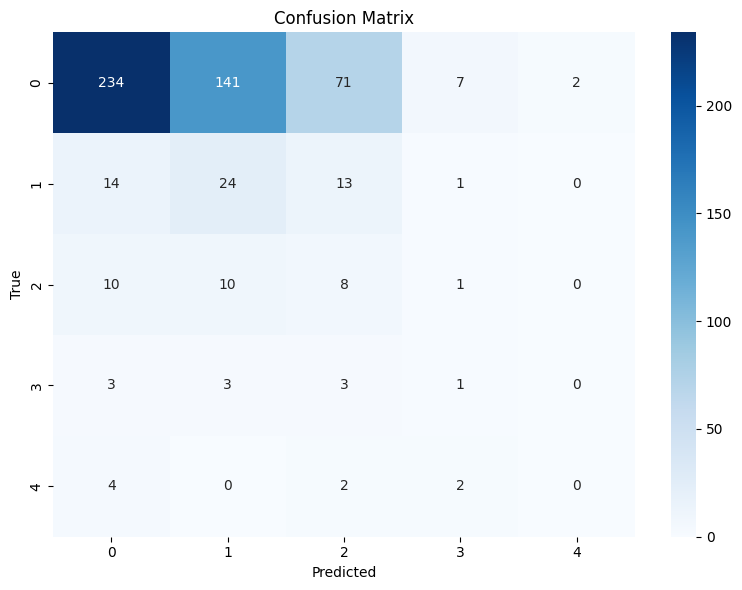


Test AUC (macro-average, OVR): 0.6491


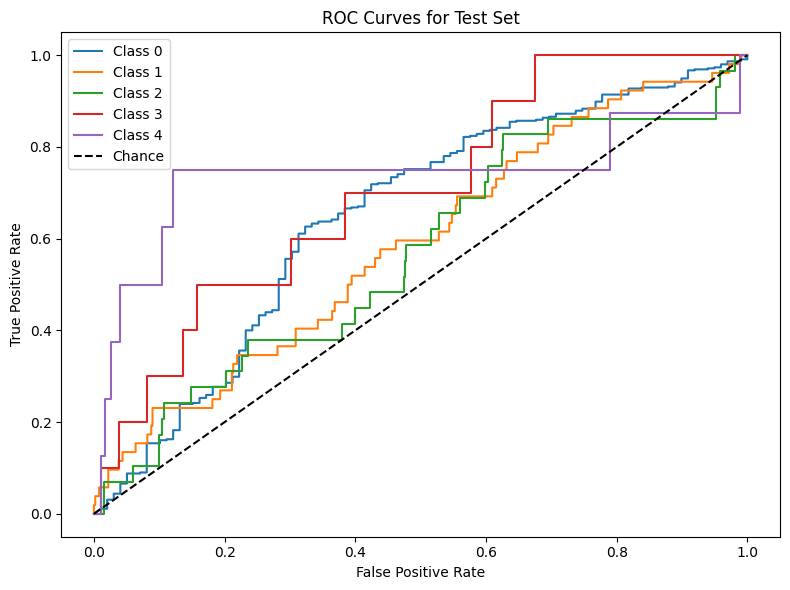


Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.53      0.65       395
           1       0.08      0.25      0.13        40
           2       0.00      0.00      0.00        24
           3       0.03      0.10      0.05        10
           4       0.12      0.38      0.18         8

    accuracy                           0.47       477
   macro avg       0.21      0.25      0.20       477
weighted avg       0.70      0.47      0.55       477



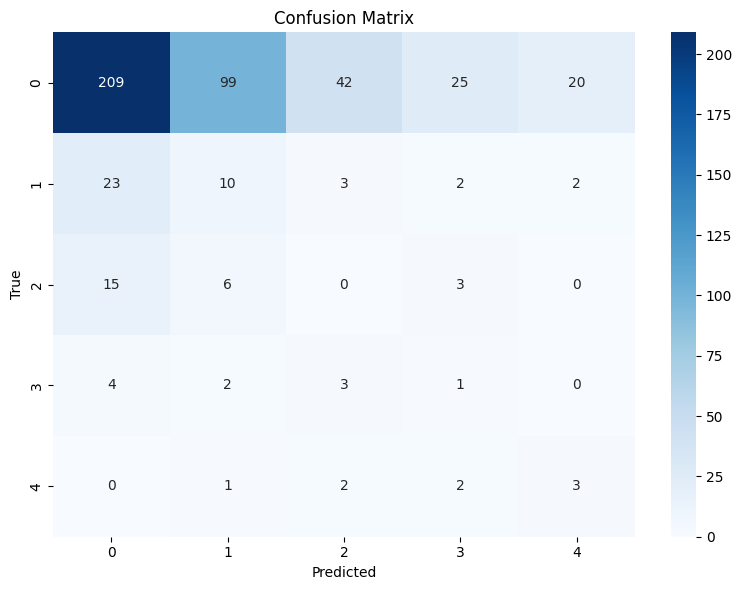


Test AUC (macro-average, OVR): 0.6327


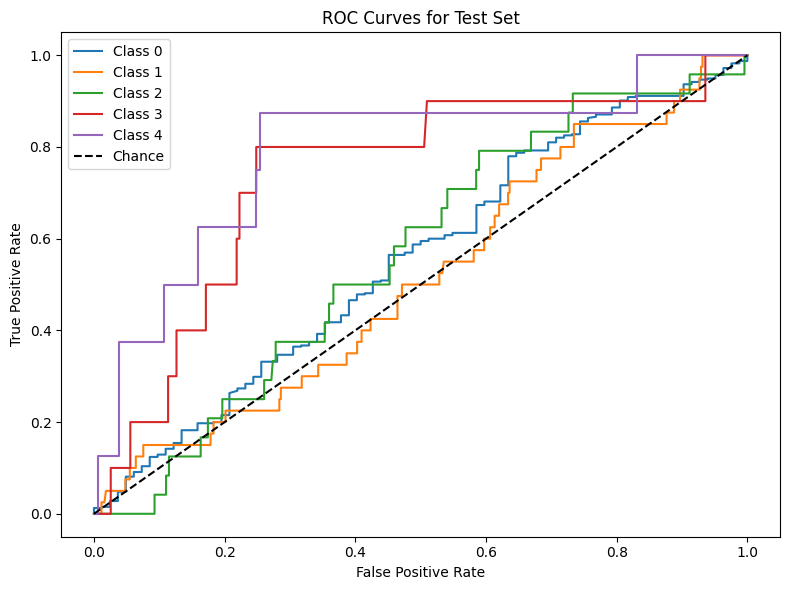

In [11]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-node-clustering/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)